# ΒΑΣΙΛΕΙΟΣ-ΜΑΡΙΟΣ ΠΑΝΑΓΑΚΗΣ
## <div> 1115201600123 </div>

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import os
import csv
import warnings
import heapq
import random
from pandas import DataFrame, read_csv
from collections import Counter
from wordcloud import WordCloud, STOPWORDS 
from gensim.models import Word2Vec
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, make_scorer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, StratifiedKFold
from sklearn import svm, metrics, preprocessing
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.extmath import softmax
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD, FastICA

pd.options.mode.chained_assignment = None  
warnings.filterwarnings('ignore')  

### Create TSV files

create a dataframe from articles.tsv file data

In [2]:
articles = pd.read_csv("./articles.tsv", delimiter="\t", names=['Id','Title','Content','Category'], header=None, encoding='latin1')

In [3]:
#split 'Category' column from the rest of the data
X = articles
y = articles['Category']

In [4]:
#get train and test dataframes 
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.2, stratify=articles['Category'], random_state = 42)

create tab-seperated train_set.tsv file 

In [5]:
train_X.to_csv("./train_set.tsv", header=False, sep='\t', index = False)

In [6]:
#totally remove 'Category' column from test set
test_X.drop(['Category'], 1, inplace=True)

create tab-seperated test_set.tsv file 

In [7]:
test_X.to_csv("./test_set.tsv", header=False, sep='\t', index = False)

### Load Data

display some samples of our initial data

In [8]:
train = pd.read_csv("./train_set.tsv", delimiter="\t", names=['Id','Title','Content','Category'], header=None)

train.head()

Id                              Title  \
0  1628   Barkley fit for match in Ireland   
1    40  Umbro profits lifted by Euro 2004   
2   850  De Niro completes box office coup   
3  1939     Pompeii gets digital make-over   
4   515  Poppins musical gets flying start   

                                             Content       Category  
0  England centre Olly Barkley has been passed fi...          sport  
1  UK sportswear firm Umbro has posted a 222% ris...       business  
2  Robert De Niro has completed a transatlantic b...  entertainment  
3  The old-fashioned audio tour of historical pla...           tech  
4  The stage adaptation of children's film Mary P...  entertainment

In [9]:
test = pd.read_csv("./test_set.tsv", delimiter="\t", names=['Id','Title','Content'], header=None)

test.head()

Id                                  Title  \
0  1222             Prime minister's questions   
1   562      Spike Lee backs student directors   
2   696        Johnny and Denise lose Passport   
3   824      How the Academy Awards flourished   
4   271  Arsenal 'may seek full share listing'   

                                             Content  
0  So who, if anyone, is playing politics with th...  
1  Film-maker Spike Lee says black representation...  
2  Johnny Vaughan and Denise Van Outen's Saturday...  
3  The 77th annual Academy Awards are taking plac...  
4  Arsenal vice-chairman David Dein has said the ...

### Data Preprocessing

In [10]:
#function that removes all non alphabetic strings 
def clean_content(text):
    
    text =  ''.join(ch for ch in text if ch.isalpha() or ch == ' ')
    
    text = text.lower() #convert text into lowercase
    
    return text

create a column for each set with cleaned 'Content' data

In [11]:
for index, row in train.iterrows():
    train.loc[index,'CleanContent'] = clean_content(train.loc[index,'Content'])

In [12]:
for index, row in test.iterrows():
    test.loc[index,'CleanContent'] = clean_content(test.loc[index,'Content'])

### Tokenization

In [13]:
tknzr = TweetTokenizer()

tokens = []
for index, row in train.iterrows(): #add each article's token in a list
    toks = tknzr.tokenize(train.loc[index,'CleanContent'])
    
    toks = [w for w in toks if not w in stopwords.words('english')] 
    
    tokens.append(toks)

#create a column in train set with articles' tokens 
train['Tokens'] = pd.Series(tokens,index=train.index)

In [14]:
tokens = []
for index, row in test.iterrows(): #add each article's token in a list
    toks = tknzr.tokenize(test.loc[index,'CleanContent'])
    
    toks = [w for w in toks if not w in stopwords.words('english')] 
    
    tokens.append(toks)
    
#create a column in test set with articles' tokens   
test['Tokens'] = pd.Series(tokens,index=test.index)

### Stemming - Lemmatization

In [15]:
lemmatizer = WordNetLemmatizer()

lemContent = []
for index, row in train.iterrows(): #add each token's lemma in a list
    lemmas = []
    for token in train.loc[index,'Tokens']:
        lemmas.append(lemmatizer.lemmatize(token))
    lemContent.append(lemmas)

#replace train set's tokens with their lemmas
train.drop(['Tokens'],1,inplace=True)
train['Tokens'] = pd.Series(lemContent,index=train.index)

In [16]:
lemmatizer = WordNetLemmatizer()

lemContent = []
for index, row in test.iterrows(): #add each token's lemma in a list
    lemmas = []
    for token in test.loc[index,'Tokens']:
        lemmas.append(lemmatizer.lemmatize(token))
    lemContent.append(lemmas)

#replace test set's tokens with their lemmas    
test.drop(['Tokens'],1,inplace=True)
test['Tokens'] = pd.Series(lemContent,index=test.index)

display some samples of our updated data

In [17]:
train.head()

Id                              Title  \
0  1628   Barkley fit for match in Ireland   
1    40  Umbro profits lifted by Euro 2004   
2   850  De Niro completes box office coup   
3  1939     Pompeii gets digital make-over   
4   515  Poppins musical gets flying start   

                                             Content       Category  \
0  England centre Olly Barkley has been passed fi...          sport   
1  UK sportswear firm Umbro has posted a 222% ris...       business   
2  Robert De Niro has completed a transatlantic b...  entertainment   
3  The old-fashioned audio tour of historical pla...           tech   
4  The stage adaptation of children's film Mary P...  entertainment   

                                        CleanContent  \
0  england centre olly barkley has been passed fi...   
1  uk sportswear firm umbro has posted a  rise in...   
2  robert de niro has completed a transatlantic b...   
3  the oldfashioned audio tour of historical plac...   
4  the stage adaptation of childrens film mary po...   

                                              Tokens  
0  [england, centre, olly, barkley, passed, fit, ...  
1  [uk, sportswear, firm, umbro, posted, rise, an...  
2  [robert, de, niro, completed, transatlantic, b...  
3  [oldfashioned, audio, tour, historical, place,...  
4  [stage, adaptation, childrens, film, mary, pop...

In [18]:
test.head()

Id                                  Title  \
0  1222             Prime minister's questions   
1   562      Spike Lee backs student directors   
2   696        Johnny and Denise lose Passport   
3   824      How the Academy Awards flourished   
4   271  Arsenal 'may seek full share listing'   

                                             Content  \
0  So who, if anyone, is playing politics with th...   
1  Film-maker Spike Lee says black representation...   
2  Johnny Vaughan and Denise Van Outen's Saturday...   
3  The 77th annual Academy Awards are taking plac...   
4  Arsenal vice-chairman David Dein has said the ...   

                                        CleanContent  \
0  so who if anyone is playing politics with the ...   
1  filmmaker spike lee says black representation ...   
2  johnny vaughan and denise van outens saturday ...   
3  the th annual academy awards are taking place ...   
4  arsenal vicechairman david dein has said the c...   

                                              Tokens  
0  [anyone, playing, politics, security, nationmi...  
1  [filmmaker, spike, lee, say, black, representa...  
2  [johnny, vaughan, denise, van, outens, saturda...  
3  [th, annual, academy, award, taking, place, fe...  
4  [arsenal, vicechairman, david, dein, said, clu...

## Data Analysis

In [19]:
allToks = []
busToks = []
enterToks = []
politToks = []
sportToks = []
techToks = []
busCount, enterCount, politCount, sportCount, techCount = (0,0,0,0,0)

for index, row in train.iterrows():
    if train.loc[index,'Category'] == 'business':
        busCount+=1
        for token in train.loc[index,'Tokens']:
            busToks.append(token)
    elif train.loc[index,'Category'] == 'entertainment':
        enterCount+=1
        for token in train.loc[index,'Tokens']:
            enterToks.append(token)
    elif train.loc[index,'Category'] == 'politics':
        politCount+=1
        for token in train.loc[index,'Tokens']:
            politToks.append(token)
    elif train.loc[index,'Category'] == 'sport':
        sportCount+=1
        for token in train.loc[index,'Tokens']:
            sportToks.append(token)
    else:
        techCount+=1
        for token in train.loc[index,'Tokens']:
            techToks.append(token)
    for token in train.loc[index,'Tokens']:
        allToks.append(token)

## Pie

illustrate the volume of each article's Category in the train set

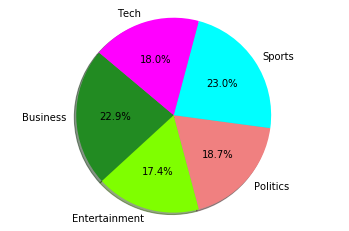

In [20]:
labels = 'Business', 'Entertainment', 'Politics', 'Sports', 'Tech'
sizes = [busCount, enterCount, politCount, sportCount, techCount]
colors = ['forestgreen', 'chartreuse', 'lightcoral', 'aqua', 'fuchsia']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

#  <h1><center>WORDCLOUDS</center></h1> 

In [21]:
#define the STOPWORDS set and update it with some user defined stopwords
stopwords = set(STOPWORDS)
stopwords.update(["said", "say", "told", "people", "bn", "year", "one", "last", "time", "new", "mr", "best", "party"])

### on business articles

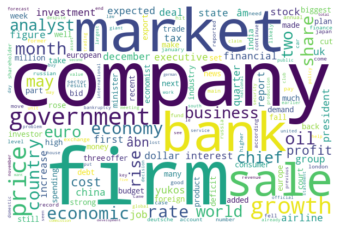

In [22]:
count = Counter(busToks)
common = ""
for word, times in count.most_common(200): #include just the 200 most common words to create the wordcloud 
    common = common + " " + word

wc = WordCloud(stopwords=stopwords, background_color="white", width=600, height=400,).generate(common)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### on entertainment articles

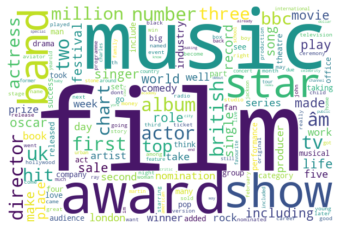

In [23]:
count = Counter(enterToks)
common = ""
for word, times in count.most_common(200): #include just the 200 most common words to create the wordcloud
    common = common + " " + word

wc = WordCloud(stopwords=stopwords, background_color="white", width=600, height=400,).generate(common)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### on politics articles

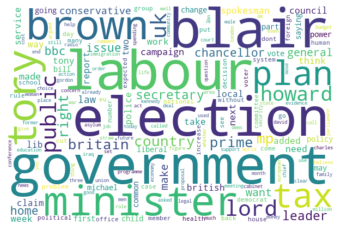

In [24]:
count = Counter(politToks)
common = ""
for word, times in count.most_common(200): #include just the 200 most common words to create the wordcloud
    common = common + " " + word

wc = WordCloud(stopwords=stopwords, background_color="white", width=600, height=400,).generate(common)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### on sports articles

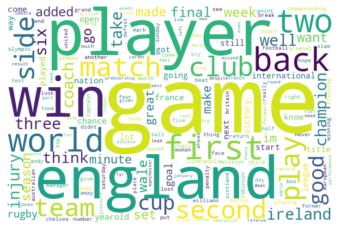

In [25]:
count = Counter(sportToks)
common = ""
for word, times in count.most_common(200): #include just the 200 most common words to create the wordcloud
    common = common + " " + word

wc = WordCloud(stopwords=stopwords, background_color="white", width=600, height=400,).generate(common)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### on tech articles

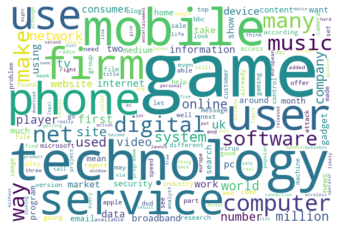

In [26]:
count = Counter(techToks)
common = ""
for word, times in count.most_common(200): #include just the 200 most common words to create the wordcloud
    common = common + " " + word

wc = WordCloud(stopwords=stopwords, background_color="white", width=600, height=400,).generate(common)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### on all articles

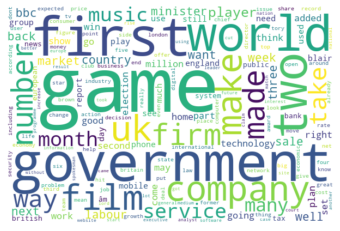

In [27]:
count = Counter(allToks)
common = ""
for word, times in count.most_common(200): #include just the 200 most common words to create the wordcloud
    common = common + " " + word

wc = WordCloud(stopwords=stopwords, background_color="white", width=600, height=400,).generate(common)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# <h1><center>CLASSIFICATION</center></h1>

### Label Preprocessing

In [28]:
#transform string labels to numerical labels
encoder = preprocessing.LabelEncoder() 

# encode train and test labels 
encoder.fit(train_Y)
train_y = encoder.transform(train_Y)

encoder.fit(test_Y)
test_y = encoder.transform(test_Y)

### Vectorization

### Counts 

In [29]:
countVectorizer = CountVectorizer(max_df=0.99, min_df=1, max_features=350, stop_words='english',
                                     strip_accents='unicode', analyzer='word')

In [30]:
bow = countVectorizer.fit_transform(train['CleanContent'])

vectors = []
for v in bow.toarray():
    vectors.append(v)

#create a column in train set with articles' words counts   
train['document-words'] = pd.Series(vectors,index=train.index)

In [31]:
bow = countVectorizer.fit_transform(test['CleanContent'])

vectors = []
for v in bow.toarray():
    vectors.append(v)

#create a column in test set with articles' words counts   
test['document-words'] = pd.Series(vectors,index=test.index)

### Tf-Idf

In [32]:
tfidfVectorizer = TfidfVectorizer(max_df=0.99, min_df=1, max_features=350, stop_words='english',
                                     strip_accents='unicode', analyzer='word')

In [33]:
tfidf = tfidfVectorizer.fit_transform(train['CleanContent'])

vectors = []
for v in tfidf.toarray():
    vectors.append(v)

#create a column in train set with articles' words tf-idf counts transformation
train['tf-idf'] = pd.Series(vectors,index=train.index)

In [34]:
tfidf = tfidfVectorizer.fit_transform(test['CleanContent'])

vectors = []
for v in tfidf.toarray():
    vectors.append(v)

#create a column in test set with articles' words tf-idf counts transformation    
test['tf-idf'] = pd.Series(vectors,index=test.index)

display some samples of our updated data after vectorization

In [35]:
train.head()

Id                              Title  \
0  1628   Barkley fit for match in Ireland   
1    40  Umbro profits lifted by Euro 2004   
2   850  De Niro completes box office coup   
3  1939     Pompeii gets digital make-over   
4   515  Poppins musical gets flying start   

                                             Content       Category  \
0  England centre Olly Barkley has been passed fi...          sport   
1  UK sportswear firm Umbro has posted a 222% ris...       business   
2  Robert De Niro has completed a transatlantic b...  entertainment   
3  The old-fashioned audio tour of historical pla...           tech   
4  The stage adaptation of children's film Mary P...  entertainment   

                                        CleanContent  \
0  england centre olly barkley has been passed fi...   
1  uk sportswear firm umbro has posted a  rise in...   
2  robert de niro has completed a transatlantic b...   
3  the oldfashioned audio tour of historical plac...   
4  the stage adaptation of childrens film mary po...   

                                              Tokens  \
0  [england, centre, olly, barkley, passed, fit, ...   
1  [uk, sportswear, firm, umbro, posted, rise, an...   
2  [robert, de, niro, completed, transatlantic, b...   
3  [oldfashioned, audio, tour, historical, place,...   
4  [stage, adaptation, childrens, film, mary, pop...   

                                      document-words  \
0  [0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...   
2  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                              tf-idf  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0634941629609...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.113...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.16922580523651679,...  
3  [0.08790247156173632, 0.0, 0.0, 0.0, 0.0, 0.0,...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [36]:
test.head()

Id                                  Title  \
0  1222             Prime minister's questions   
1   562      Spike Lee backs student directors   
2   696        Johnny and Denise lose Passport   
3   824      How the Academy Awards flourished   
4   271  Arsenal 'may seek full share listing'   

                                             Content  \
0  So who, if anyone, is playing politics with th...   
1  Film-maker Spike Lee says black representation...   
2  Johnny Vaughan and Denise Van Outen's Saturday...   
3  The 77th annual Academy Awards are taking plac...   
4  Arsenal vice-chairman David Dein has said the ...   

                                        CleanContent  \
0  so who if anyone is playing politics with the ...   
1  filmmaker spike lee says black representation ...   
2  johnny vaughan and denise van outens saturday ...   
3  the th annual academy awards are taking place ...   
4  arsenal vicechairman david dein has said the c...   

                                              Tokens  \
0  [anyone, playing, politics, security, nationmi...   
1  [filmmaker, spike, lee, say, black, representa...   
2  [johnny, vaughan, denise, van, outens, saturda...   
3  [th, annual, academy, award, taking, place, fe...   
4  [arsenal, vicechairman, david, dein, said, clu...   

                                      document-words  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ...   
1  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                              tf-idf  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.17810371705944092,...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1538183424875...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.1170964737219121, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

insert 'document-words' and 'tf-idf' columns to arrays for both training and test sets 

In [37]:
train_bow = np.asarray(train['document-words'].tolist())
train_tfidf = np.asarray(train['tf-idf'].tolist())

In [38]:
test_bow = np.asarray(test['document-words'].tolist())
test_tfidf = np.asarray(test['tf-idf'].tolist())

### Evaluation Functions

In [39]:
md={}

#function that uses values from a dictionary to create a dataframe to store model evaluation values
def model_dataframe(classifier, avg_prec, prec_std, avg_rec, rec_std, avg_f1, f1_std, avg_acc, acc_std):

    md['classifier'] = classifier
    md['avg-precision'] = avg_prec
    md['precision-std'] = prec_std
    md['avg-recall'] = avg_rec
    md['recall-std'] = rec_std
    md['avg-f1-score'] = avg_f1
    md['f1-score-std'] = f1_std
    md['avg-accuracy'] = avg_acc
    md['accuracy-std'] = acc_std
    
    df = pd.DataFrame(data=md) #create dataframe from dictionary data
    
    return df 

create a dataframe to store the prediction-accuracy values of the classifiers

In [40]:
cl_dic = {'SVM':['-','-'], 'RF':['-','-'], 'NB':['-','-'], 'KNN':['-','-']}

cl_df = pd.DataFrame.from_dict(cl_dic, orient='index', columns=['BOW','TF-IDF'])

In [41]:
#define k-fold evaluation methods
numOfFolds = 10
cv1 = KFold(n_splits=numOfFolds, shuffle=True)
cv2 = StratifiedKFold(n_splits=numOfFolds, shuffle=True)

In [42]:
#scoring methods that calculate the precision, recall and f-mesure values for every fold of k-fold cross validation 

def precEval(y_true, y_pred):
    fold_report = classification_report(y_true, y_pred, output_dict=True)
    prec = fold_report['macro avg']['precision']
    return prec

def recEval(y_true, y_pred):
    fold_report = classification_report(y_true, y_pred, output_dict=True)
    rec = fold_report['macro avg']['recall']
    return rec

def f1Eval(y_true, y_pred):
    fold_report = classification_report(y_true, y_pred, output_dict=True)
    f1 = fold_report['macro avg']['f1-score']
    return f1

In [43]:
#function that creates ROC plots for multiclass classifiers 
#based on 10-fold Cross Validation on train set and predictions on test set
def multiclass_roc_plot(clf, train_X, train_y, test_X, test_y, title1, title2):
    classes=['Business', 'Entertainment', 'Politics', 'Sports', 'Tech']
    colors = ['forestgreen', 'chartreuse', 'lightcoral', 'aqua', 'fuchsia']
    clen = len(classes)    
    clf_name = type(clf).__name__
    
    #predict probability with different function for every classifier
    if clf_name == 'SVC':
        score_y = clf.decision_function(test_X)
        method='decision_function'
    elif clf_name == 'ComplementNB' or clf_name == 'BernoulliNB':
        score_y = clf.predict_log_proba(test_X)
        method='predict_log_proba'
    elif clf_name == 'RandomForestClassifier' or clf_name == 'MyKnnClassifier':
        score_y = clf.predict_proba(test_X)
        method='predict_proba'    
     
    plt.figure(figsize=(7,4), dpi=120) 

    plt.subplot(1,2,1)
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    y_bin = label_binarize(train_y, classes=[0, 1, 2, 3, 4]) #binarize class labels
    y_score = cross_val_predict(clf, train_X, train_y, cv=10, method=method) #cross validation prediction
 
    for i in range(clen):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # roc for each class
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=10)
    plt.ylabel('True Positive Rate', fontsize=10)
    plt.title(title1, fontsize=10)
    
    for i, color in zip(range(clen),colors):
        plt.plot(fpr[i], tpr[i], color=color, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], classes[i]))
    
    plt.legend(loc='lower right', prop={'size': 5})
    plt.grid(alpha=.4)
    sns.despine()
    
    plt.subplot(1,2,2)
    fpr = {}
    tpr = {}
    roc_auc = {}
     
    test_y_dummies = pd.get_dummies(test_y, drop_first=False).values #get dummies
    for i in range(clen):
        fpr[i], tpr[i], _ = roc_curve(test_y_dummies[:, i], score_y[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # roc for each class
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=10)
    plt.ylabel('True Positive Rate', fontsize=10)
    plt.title(title2, fontsize=11)
        
    for i, color in zip(range(clen),colors):
        plt.plot(fpr[i], tpr[i], color=color, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], classes[i]))
    
    plt.legend(loc='lower right', prop={'size': 5})
    plt.grid(alpha=.4)
    sns.despine()

## SVM

In [44]:
#initialize empty lists to store column values of the dataframe
classifier, avg_prec, prec_std, avg_rec, rec_std, avg_f1, f1_std, avg_acc, acc_std = ([] for i in range(9))

### Counts - rbf kernel  

In [45]:
classifier.append('SVM(bow-rbf_kernel)')

svc_bow_rbf = svm.SVC(C=1000, kernel='rbf', gamma=0.001)
svc_bow_rbf.fit(train_bow, train_y)

y_pred_bow_rbf = svc_bow_rbf.predict(test_bow) #prediction on test set

#stratified 10-fold Cross Validation on train set
prec = cross_val_score(svc_bow_rbf, train_bow, train_y, cv=cv2, scoring=make_scorer(precEval))
rec = cross_val_score(svc_bow_rbf, train_bow, train_y, cv=cv2, scoring=make_scorer(recEval))
f1 = cross_val_score(svc_bow_rbf, train_bow, train_y, cv=cv2, scoring=make_scorer(f1Eval))
acc = cross_val_score(svc_bow_rbf, train_bow, train_y, cv=cv2, scoring='accuracy')

av_prec = "%.3f%%" % (prec.mean() * 100)
av_rec = "%.3f%%" % (rec.mean() * 100)
av_f1 = "%.3f%%" % (f1.mean() * 100)
av_acc = "%.3f%%" % (acc.mean() * 100)

avg_prec.append(av_prec), prec_std.append(prec.std())
avg_rec.append(av_rec), rec_std.append(rec.std())
avg_f1.append(av_f1), f1_std.append(f1.std())
avg_acc.append(av_acc), acc_std.append(acc.std())

bow_rbf_svc = "%.3f%%" % (metrics.accuracy_score(test_y, y_pred_bow_rbf) * 100)

### Counts - linear kernel  

In [46]:
classifier.append('SVM(bow-linear_kernel)')

svc_bow_lin = svm.SVC(C=1, kernel='linear')
svc_bow_lin.fit(train_bow, train_y)

y_pred_bow_lin = svc_bow_lin.predict(test_bow) #prediction on test set

#stratified 10-fold Cross Validation on train set
prec = cross_val_score(svc_bow_lin, train_bow, train_y, cv=cv2, scoring=make_scorer(precEval))
rec = cross_val_score(svc_bow_lin, train_bow, train_y, cv=cv2, scoring=make_scorer(recEval))
f1 = cross_val_score(svc_bow_lin, train_bow, train_y, cv=cv2, scoring=make_scorer(f1Eval))
acc = cross_val_score(svc_bow_lin, train_bow, train_y, cv=cv2, scoring='accuracy')

av_prec = "%.3f%%" % (prec.mean() * 100)
av_rec = "%.3f%%" % (rec.mean() * 100)
av_f1 = "%.3f%%" % (f1.mean() * 100)
av_acc = "%.3f%%" % (acc.mean() * 100)

avg_prec.append(av_prec), prec_std.append(prec.std())
avg_rec.append(av_rec), rec_std.append(rec.std())
avg_f1.append(av_f1), f1_std.append(f1.std())
avg_acc.append(av_acc), acc_std.append(acc.std())

bow_lin_svc = "%.3f%%" % (metrics.accuracy_score(test_y, y_pred_bow_lin) * 100)

In [47]:
if bow_rbf_svc >= bow_lin_svc:
    cl_df.loc['SVM','BOW'] = bow_rbf_svc
else:
    cl_df.loc['SVM','BOW'] = bow_lin_svc

### Tf-Idf - rbf kernel  

In [48]:
classifier.append('SVM(tfidf-rbf_kernel)')

svc_tfidf_rbf = svm.SVC(C=100, kernel='rbf', gamma=0.001)
svc_tfidf_rbf.fit(train_tfidf, train_y)

y_pred_tfidf_rbf = svc_tfidf_rbf.predict(test_tfidf) #prediction on test set

#stratified 10-fold Cross Validation on train set
prec = cross_val_score(svc_tfidf_rbf, train_tfidf, train_y, cv=cv2, scoring=make_scorer(precEval))
rec = cross_val_score(svc_tfidf_rbf, train_tfidf, train_y, cv=cv2, scoring=make_scorer(recEval))
f1 = cross_val_score(svc_tfidf_rbf, train_tfidf, train_y, cv=cv2, scoring=make_scorer(f1Eval))
acc = cross_val_score(svc_tfidf_rbf, train_tfidf, train_y, cv=cv2, scoring='accuracy')

av_prec = "%.3f%%" % (prec.mean() * 100)
av_rec = "%.3f%%" % (rec.mean() * 100)
av_f1 = "%.3f%%" % (f1.mean() * 100)
av_acc = "%.3f%%" % (acc.mean() * 100)

avg_prec.append(av_prec), prec_std.append(prec.std())
avg_rec.append(av_rec), rec_std.append(rec.std())
avg_f1.append(av_f1), f1_std.append(f1.std())
avg_acc.append(av_acc), acc_std.append(acc.std())

tfidf_rbf_svc = "%.3f%%" % (metrics.accuracy_score(test_y, y_pred_tfidf_rbf) * 100)

### Tf-Idf - linear kernel  

In [49]:
classifier.append('SVM(tfidf-linear_kernel)')

svc_tfidf_lin = svm.SVC(C=1, kernel='linear', gamma=0.001)
svc_tfidf_lin.fit(train_tfidf, train_y)

y_pred_tfidf_lin = svc_tfidf_lin.predict(test_tfidf) #prediction on test set

#stratified 10-fold Cross Validation on train set
prec = cross_val_score(svc_tfidf_lin, train_tfidf, train_y, cv=cv2, scoring=make_scorer(precEval))
rec = cross_val_score(svc_tfidf_lin, train_tfidf, train_y, cv=cv2, scoring=make_scorer(recEval))
f1 = cross_val_score(svc_tfidf_lin, train_tfidf, train_y, cv=cv2, scoring=make_scorer(f1Eval))
acc = cross_val_score(svc_tfidf_lin, train_tfidf, train_y, cv=cv2, scoring='accuracy')

av_prec = "%.3f%%" % (prec.mean() * 100)
av_rec = "%.3f%%" % (rec.mean() * 100)
av_f1 = "%.3f%%" % (f1.mean() * 100)
av_acc = "%.3f%%" % (acc.mean() * 100)

avg_prec.append(av_prec), prec_std.append(prec.std())
avg_rec.append(av_rec), rec_std.append(rec.std())
avg_f1.append(av_f1), f1_std.append(f1.std())
avg_acc.append(av_acc), acc_std.append(acc.std())

tfidf_lin_svc = "%.3f%%" % (metrics.accuracy_score(test_y, y_pred_tfidf_lin) * 100)

In [50]:
if tfidf_rbf_svc >= tfidf_lin_svc:
    cl_df.loc['SVM','TF-IDF'] = tfidf_rbf_svc
else:
    cl_df.loc['SVM','TF-IDF'] = tfidf_lin_svc

### Model Evaluation

In [51]:
svm_mdf = model_dataframe(classifier, avg_prec, prec_std, avg_rec, rec_std, avg_f1, f1_std, avg_acc, acc_std)
svm_mdf

classifier avg-precision  precision-std avg-recall  \
0       SVM(bow-rbf_kernel)       93.570%       0.013956    93.144%   
1    SVM(bow-linear_kernel)       93.046%       0.016292    93.376%   
2     SVM(tfidf-rbf_kernel)       94.404%       0.016990    94.078%   
3  SVM(tfidf-linear_kernel)       95.104%       0.016645    94.625%   

   recall-std avg-f1-score  f1-score-std avg-accuracy  accuracy-std  
0    0.014615      93.043%      0.018569      93.596%      0.017801  
1    0.019425      92.998%      0.010407      93.483%      0.017801  
2    0.021310      94.168%      0.011755      94.888%      0.015979  
3    0.015701      94.769%      0.016117      94.551%      0.013306

### ROC Plots

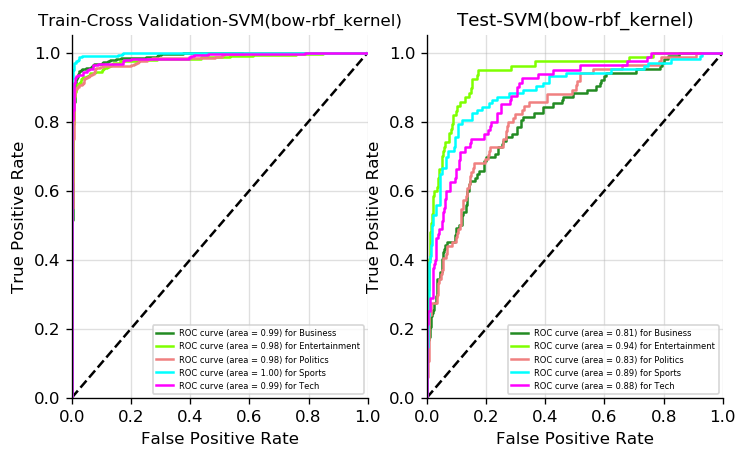

In [52]:
multiclass_roc_plot(svc_bow_rbf, train_bow, train_y, test_bow, test_y, 
                    title1='Train-Cross Validation-SVM(bow-rbf_kernel)', title2='Test-SVM(bow-rbf_kernel)')

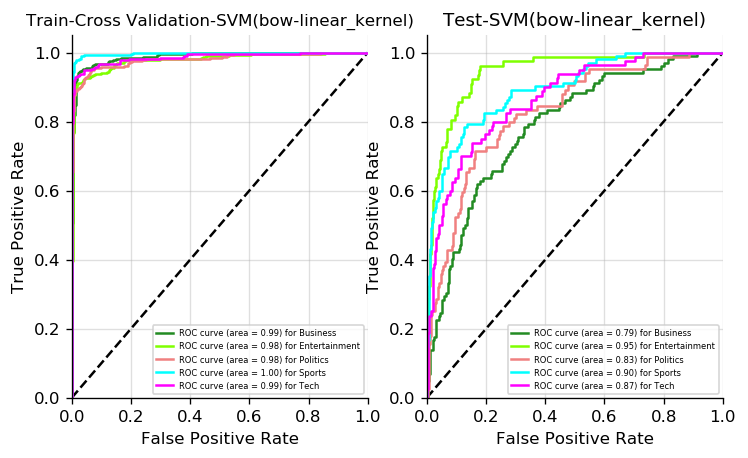

In [53]:
multiclass_roc_plot(svc_bow_lin, train_bow, train_y, test_bow, test_y, 
                    title1='Train-Cross Validation-SVM(bow-linear_kernel)', title2='Test-SVM(bow-linear_kernel)')

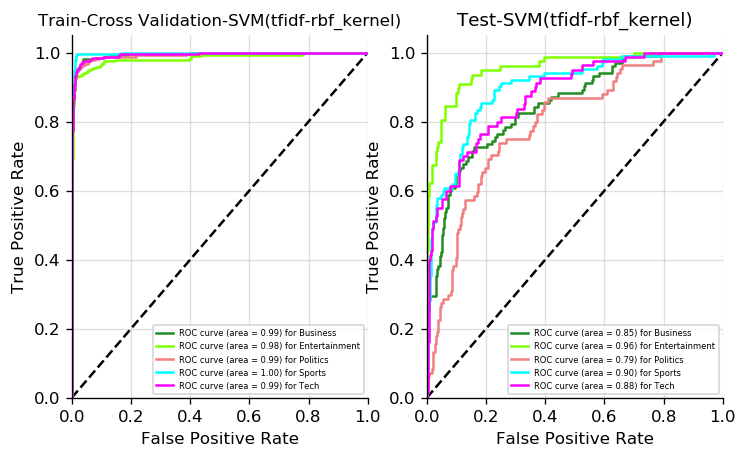

In [54]:
multiclass_roc_plot(svc_tfidf_rbf, train_tfidf, train_y, test_tfidf, test_y, 
                    title1='Train-Cross Validation-SVM(tfidf-rbf_kernel)', title2='Test-SVM(tfidf-rbf_kernel)')

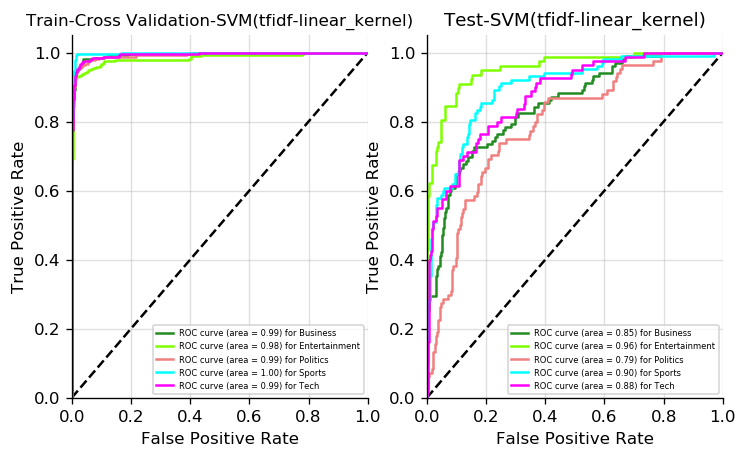

In [55]:
multiclass_roc_plot(svc_tfidf_rbf, train_tfidf, train_y, test_tfidf, test_y, 
                    title1='Train-Cross Validation-SVM(tfidf-linear_kernel)', title2='Test-SVM(tfidf-linear_kernel)')

## Random Forest

In [56]:
#initialize empty lists to store column values of the dataframe
classifier, avg_prec, prec_std, avg_rec, rec_std, avg_f1, f1_std, avg_acc, acc_std = ([] for i in range(9))

### Counts

In [57]:
classifier.append('RF(bow)') 

rf_bow = RandomForestClassifier(n_estimators = 1000, max_depth = 90, min_samples_split = 12,  
                                 min_samples_leaf = 3, max_features = 3, max_leaf_nodes = 15)
rf_bow.fit(train_bow, train_y)

y_pred_rf_bow = rf_bow.predict(test_bow) #prediction on test set

#stratified 10-fold Cross Validation on train set
prec = cross_val_score(rf_bow, train_bow, train_y, cv=cv2, scoring=make_scorer(precEval))
rec = cross_val_score(rf_bow, train_bow, train_y, cv=cv2, scoring=make_scorer(recEval))
f1 = cross_val_score(rf_bow, train_bow, train_y, cv=cv2, scoring=make_scorer(f1Eval))
acc = cross_val_score(rf_bow, train_bow, train_y, cv=cv2, scoring='accuracy')

av_prec = "%.3f%%" % (prec.mean() * 100)
av_rec = "%.3f%%" % (rec.mean() * 100)
av_f1 = "%.3f%%" % (f1.mean() * 100)
av_acc = "%.3f%%" % (acc.mean() * 100)

avg_prec.append(av_prec), prec_std.append(prec.std())
avg_rec.append(av_rec), rec_std.append(rec.std())
avg_f1.append(av_f1), f1_std.append(f1.std())
avg_acc.append(av_acc), acc_std.append(acc.std())

cl_df.loc['RF','BOW'] = "%.3f%%" % (metrics.accuracy_score(test_y, y_pred_rf_bow) * 100)

### Tf-Idf 

In [58]:
classifier.append('RF(tfidf)') 

rf_tfidf = RandomForestClassifier(n_estimators = 1000, max_depth = 30, min_samples_split = 12,  
                                 min_samples_leaf = 3, max_features = 3, max_leaf_nodes = 15)
rf_tfidf.fit(train_tfidf, train_y)

y_pred_rf_tfidf = rf_tfidf.predict(test_tfidf) #prediction on test set

#stratified 10-fold Cross Validation on train set
prec = cross_val_score(rf_tfidf, train_tfidf, train_y, cv=cv2, scoring=make_scorer(precEval))
rec = cross_val_score(rf_tfidf, train_tfidf, train_y, cv=cv2, scoring=make_scorer(recEval))
f1 = cross_val_score(rf_tfidf, train_tfidf, train_y, cv=cv2, scoring=make_scorer(f1Eval))
acc = cross_val_score(rf_tfidf, train_tfidf, train_y, cv=cv2, scoring='accuracy')

av_prec = "%.3f%%" % (prec.mean() * 100)
av_rec = "%.3f%%" % (rec.mean() * 100)
av_f1 = "%.3f%%" % (f1.mean() * 100)
av_acc = "%.3f%%" % (acc.mean() * 100)

avg_prec.append(av_prec), prec_std.append(prec.std())
avg_rec.append(av_rec), rec_std.append(rec.std())
avg_f1.append(av_f1), f1_std.append(f1.std())
avg_acc.append(av_acc), acc_std.append(acc.std())

cl_df.loc['RF','TF-IDF'] = "%.3f%%" % (metrics.accuracy_score(test_y, y_pred_rf_tfidf) * 100)

### Model Evaluation

In [59]:
rf_mdf = model_dataframe(classifier, avg_prec, prec_std, avg_rec, rec_std, avg_f1, f1_std, avg_acc, acc_std)
rf_mdf

classifier avg-precision  precision-std avg-recall  recall-std avg-f1-score  \
0    RF(bow)       92.260%       0.020102    89.809%    0.015873      90.191%   
1  RF(tfidf)       92.448%       0.014139    90.143%    0.027796      90.763%   

   f1-score-std avg-accuracy  accuracy-std  
0      0.026000      90.899%      0.026327  
1      0.014185      91.067%      0.012675

### ROC Plots

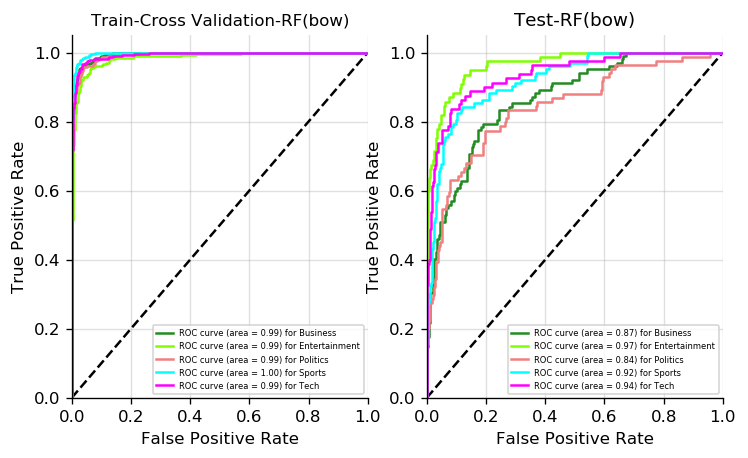

In [60]:
multiclass_roc_plot(rf_bow, train_bow, train_y, test_bow, test_y, 
                    title1='Train-Cross Validation-RF(bow)', title2='Test-RF(bow)')

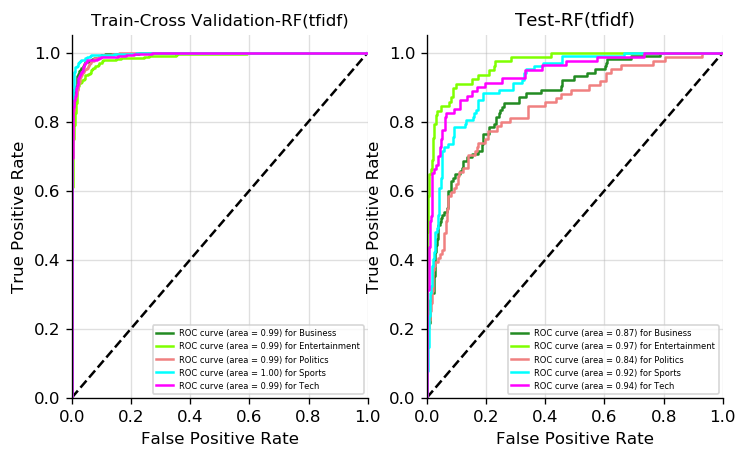

In [61]:
multiclass_roc_plot(rf_tfidf, train_tfidf, train_y, test_tfidf, test_y, 
                    title1='Train-Cross Validation-RF(tfidf)', title2='Test-RF(tfidf)')

## Naive Bayes

In [62]:
#initialize empty lists to store column values of the dataframe
classifier, avg_prec, prec_std, avg_rec, rec_std, avg_f1, f1_std, avg_acc, acc_std = ([] for i in range(9))

### Counts

In [63]:
classifier.append('CNB(bow)') 
# classifier.append('BNB(bow)')

nb_bow = ComplementNB() #Complement Naive Bayes (an adaptation of Multinomial Naive Bayes suited for imbalanced data sets)
# nb_bow = BernoulliNB() #Bernoulli Naive Bayes (data that is distributed according to multivariate Bernoulli distributions)

nb_bow.fit(train_bow, train_y)

y_pred_nb_bow = nb_bow.predict(test_bow) #prediction on test set

#stratified 10-fold Cross Validation on train set
prec = cross_val_score(nb_bow, train_bow, train_y, cv=cv2, scoring=make_scorer(precEval))
rec = cross_val_score(nb_bow, train_bow, train_y, cv=cv2, scoring=make_scorer(recEval))
f1 = cross_val_score(nb_bow, train_bow, train_y, cv=cv2, scoring=make_scorer(f1Eval))
acc = cross_val_score(nb_bow, train_bow, train_y, cv=cv2, scoring='accuracy')

av_prec = "%.3f%%" % (prec.mean() * 100)
av_rec = "%.3f%%" % (rec.mean() * 100)
av_f1 = "%.3f%%" % (f1.mean() * 100)
av_acc = "%.3f%%" % (acc.mean() * 100)

avg_prec.append(av_prec), prec_std.append(prec.std())
avg_rec.append(av_rec), rec_std.append(rec.std())
avg_f1.append(av_f1), f1_std.append(f1.std())
avg_acc.append(av_acc), acc_std.append(acc.std())

cl_df.loc['NB','BOW'] = "%.3f%%" % (metrics.accuracy_score(test_y, y_pred_nb_bow) * 100)

### Tf-Idf 

In [64]:
classifier.append('CNB(tfidf)') 
# classifier.append('BNB(tfidf)')

nb_tfidf = ComplementNB() #Complement Naive Bayes (an adaptation of Multinomial Naive Bayes suited for imbalanced data sets)
# nb_tfidf = BernoulliNB() #Bernoulli Naive Bayes (data that is distributed according to multivariate Bernoulli distributions)

nb_tfidf.fit(train_tfidf, train_y)

y_pred_nb_tfidf = nb_bow.predict(test_tfidf) #prediction on test set

#stratified 10-fold Cross Validation on train set
prec = cross_val_score(nb_tfidf, train_tfidf, train_y, cv=cv2, scoring=make_scorer(precEval))
rec = cross_val_score(nb_tfidf, train_tfidf, train_y, cv=cv2, scoring=make_scorer(recEval))
f1 = cross_val_score(nb_tfidf, train_tfidf, train_y, cv=cv2, scoring=make_scorer(f1Eval))
acc = cross_val_score(nb_tfidf, train_tfidf, train_y, cv=cv2, scoring='accuracy')

av_prec = "%.3f%%" % (prec.mean() * 100)
av_rec = "%.3f%%" % (rec.mean() * 100)
av_f1 = "%.3f%%" % (f1.mean() * 100)
av_acc = "%.3f%%" % (acc.mean() * 100)

avg_prec.append(av_prec), prec_std.append(prec.std())
avg_rec.append(av_rec), rec_std.append(rec.std())
avg_f1.append(av_f1), f1_std.append(f1.std())
avg_acc.append(av_acc), acc_std.append(acc.std())

cl_df.loc['NB','TF-IDF'] = "%.3f%%" % (metrics.accuracy_score(test_y, y_pred_nb_tfidf) * 100)

### Model Evaluation

In [65]:
nb_mdf = model_dataframe(classifier, avg_prec, prec_std, avg_rec, rec_std, avg_f1, f1_std, avg_acc, acc_std)
nb_mdf

classifier avg-precision  precision-std avg-recall  recall-std  \
0    CNB(bow)       91.561%       0.017583    90.621%    0.020026   
1  CNB(tfidf)       92.037%       0.011374    91.164%    0.027949   

  avg-f1-score  f1-score-std avg-accuracy  accuracy-std  
0      90.778%      0.014648      91.292%      0.013588  
1      91.293%      0.025792      91.910%      0.014906

### ROC Plots

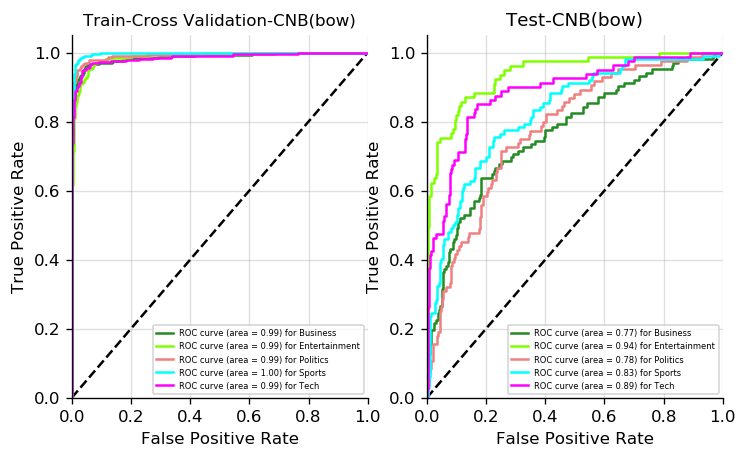

In [66]:
multiclass_roc_plot(nb_bow, train_bow, train_y, test_bow, test_y, 
                    title1='Train-Cross Validation-CNB(bow)', title2='Test-CNB(bow)')

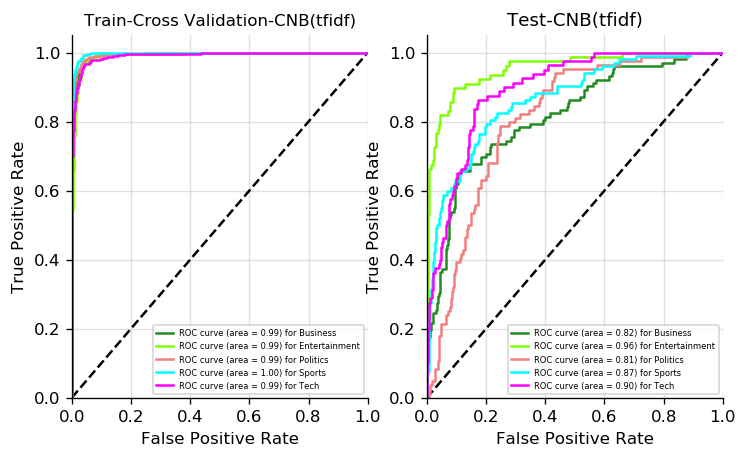

In [67]:
multiclass_roc_plot(nb_tfidf, train_tfidf, train_y, test_tfidf, test_y, 
                    title1='Train-Cross Validation-CNB(tfidf)', title2='Test-CNB(tfidf)')

## k-Nearest Neighbor

In [68]:
#function that implements a majority voting algorithm in a linear time - constant space way
def majority_voting(lab_list):
    cand = -1
    count = 0
    
    for l in lab_list:
        if count != 0: 
            count += 1 if cand == l else -1
        else: 
            cand = l
            count = 1

    #return majority element if it appears more than k/2 times in list of labels, else return a random label in list
    return cand if lab_list.count(cand) >= len(lab_list) // 2 else random.choice(lab_list)

In [69]:
#my own implementation of k-Nearest Neighbor Classifier
class MyKnnClassifier(BaseEstimator):  
    
    def __init__(self, k=10):
        self.k = k
        
    def fit(self, train_X, train_y):
        train_X, train_y = check_X_y(train_X, train_y) #check if train_X and train_y have correct shape
        
        self.classes_ = unique_labels(train_y) #store the fitted classes 
        self.X_ = train_X
        self.y_ = train_y
        
        return self
        
    def predict(self, test_X):
        check_is_fitted(self) #check if fit() had been executed

        cosim = cosine_similarity(test_X, self.X_) #calculate cosine similarity between train and test sets
        top_ind = [(heapq.nlargest((self.k+1), range(len(ind)), ind.take)) for ind in cosim] # get k most similar indices
        top_lab = [[self.y_[l] for l in ind[:self.k]] for ind in top_ind] # convert indices to labels
        
        #get prediction using a majority voting algorithm
        pred = [majority_voting(ind) for ind in top_lab]
        pred = np.array(pred)

        return pred
    
    def predict_proba(self, test_X):
        cosim = cosine_similarity(test_X, self.X_) #calculate cosine similarity between train and test sets
        neg_cosim = np.negative(cosim) #get negative distance so that the probability is inversely proportional to distance
        
        #use a "soft" nearest neighbour classification (softmax(x) = np.exp(x)/sum(np.exp(x)))
        prob = softmax(neg_cosim)
        
        return prob 

In [70]:
#initialize empty lists to store column values of the dataframe
classifier, avg_prec, prec_std, avg_rec, rec_std, avg_f1, f1_std, avg_acc, acc_std = ([] for i in range(9))

### Counts

In [71]:
classifier.append('KNN(bow)') 

knn_bow = MyKnnClassifier(k=51)
knn_bow.fit(train_bow, train_y)

y_pred_knn_bow = knn_bow.predict(test_bow) #prediction on test set

#stratified 10-fold Cross Validation on train set
prec = cross_val_score(knn_bow, train_bow, train_y, cv=cv2, scoring=make_scorer(precEval))
rec = cross_val_score(knn_bow, train_bow, train_y, cv=cv2, scoring=make_scorer(recEval))
f1 = cross_val_score(knn_bow, train_bow, train_y, cv=cv2, scoring=make_scorer(f1Eval))
acc = cross_val_score(knn_bow, train_bow, train_y, cv=cv2, scoring='accuracy')

av_prec = "%.3f%%" % (prec.mean() * 100)
av_rec = "%.3f%%" % (rec.mean() * 100)
av_f1 = "%.3f%%" % (f1.mean() * 100)
av_acc = "%.3f%%" % (acc.mean() * 100)

avg_prec.append(av_prec), prec_std.append(prec.std())
avg_rec.append(av_rec), rec_std.append(rec.std())
avg_f1.append(av_f1), f1_std.append(f1.std())
avg_acc.append(av_acc), acc_std.append(acc.std())

cl_df.loc['KNN','BOW']  = "%.3f%%" % (metrics.accuracy_score(test_y, y_pred_knn_bow) * 100)

### Tf-Idf 

In [72]:
classifier.append('KNN(tfidf)') 

knn_tfidf = MyKnnClassifier(k=44)
knn_tfidf.fit(train_tfidf, train_y)

y_pred_knn_tfidf = knn_tfidf.predict(test_tfidf) #prediction on test set

#stratified 10-fold Cross Validation on train set
prec = cross_val_score(knn_tfidf, train_tfidf, train_y, cv=cv2, scoring=make_scorer(precEval))
rec = cross_val_score(knn_tfidf, train_tfidf, train_y, cv=cv2, scoring=make_scorer(recEval))
f1 = cross_val_score(knn_tfidf, train_tfidf, train_y, cv=cv2, scoring=make_scorer(f1Eval))
acc = cross_val_score(knn_tfidf, train_tfidf, train_y, cv=cv2, scoring='accuracy')

av_prec = "%.3f%%" % (prec.mean() * 100)
av_rec = "%.3f%%" % (rec.mean() * 100)
av_f1 = "%.3f%%" % (f1.mean() * 100)
av_acc = "%.3f%%" % (acc.mean() * 100)

avg_prec.append(av_prec), prec_std.append(prec.std())
avg_rec.append(av_rec), rec_std.append(rec.std())
avg_f1.append(av_f1), f1_std.append(f1.std())
avg_acc.append(av_acc), acc_std.append(acc.std())

cl_df.loc['KNN','TF-IDF'] = "%.3f%%" % (metrics.accuracy_score(test_y, y_pred_knn_tfidf) * 100)

### Model Evaluation

In [73]:
knn_mdf = model_dataframe(classifier, avg_prec, prec_std, avg_rec, rec_std, avg_f1, f1_std, avg_acc, acc_std)
knn_mdf

classifier avg-precision  precision-std avg-recall  recall-std  \
0    KNN(bow)       83.939%       0.023962    84.328%    0.021741   
1  KNN(tfidf)       88.278%       0.025697    88.651%    0.023333   

  avg-f1-score  f1-score-std avg-accuracy  accuracy-std  
0      82.888%      0.031403      84.494%      0.033160  
1      89.094%      0.024777      89.157%      0.023441

### ROC Plots

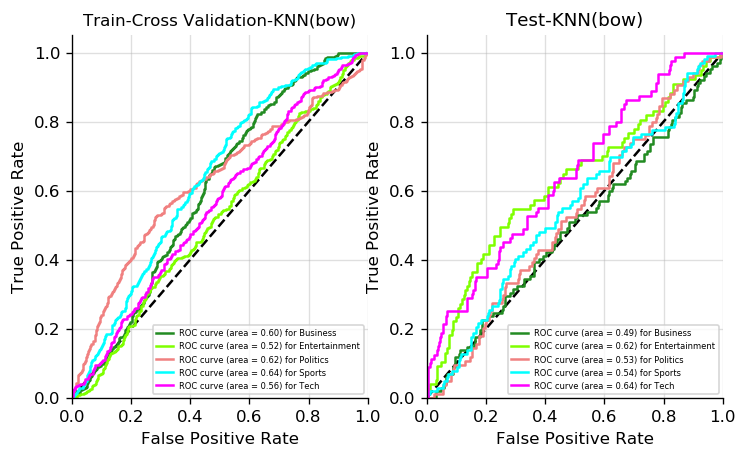

In [74]:
multiclass_roc_plot(knn_bow, train_bow, train_y, test_bow, test_y, 
                    title1='Train-Cross Validation-KNN(bow)', title2='Test-KNN(bow)')

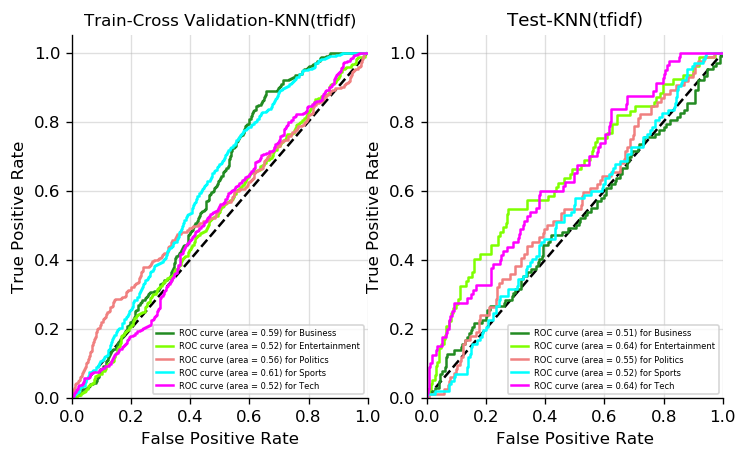

In [75]:
multiclass_roc_plot(knn_tfidf, train_tfidf, train_y, test_tfidf, test_y, 
                    title1='Train-Cross Validation-KNN(tfidf)', title2='Test-KNN(tfidf)')

### Classifiers Prediction-Accuracy Evaluation

In [76]:
cl_df

BOW   TF-IDF
SVM  60.225%  61.573%
RF   66.966%  68.090%
NB   56.404%  58.427%
KNN  45.393%  54.157%

# <h1><center>Beat the Benchmark - SVM(tfidf-rbf_kernel)</center></h1>

create a dataframe to store the prediction-accuracy value of the optimized SVM classifier

In [77]:
cl_ext_dic = {'SVM':['-']}

cl_ext_df = pd.DataFrame.from_dict(cl_ext_dic, orient='index', columns=['TF-IDF'])

create a column for each set with cleaned 'Title' data

In [78]:
for index, row in train.iterrows():
    train.loc[index,'CleanTitle'] = clean_content(train.loc[index,'Title'])

In [79]:
for index, row in test.iterrows():
    test.loc[index,'CleanTitle'] = clean_content(test.loc[index,'Title'])

create new dataframe columns including both 'CleanTitle' and 'CleanContent' data

In [80]:
train['CleanText'] = train[['CleanTitle', 'CleanContent']].agg(' '.join, axis=1)
test['CleanText'] = test[['CleanTitle', 'CleanContent']].agg(' '.join, axis=1)

In [81]:
tfidfVectorizer = TfidfVectorizer(max_df=0.99, min_df=1, max_features=350, stop_words='english',
                                    strip_accents='unicode', analyzer='word', token_pattern=r'\w+', 
                                    use_idf=True, smooth_idf=True, sublinear_tf=True)

tfidf = tfidfVectorizer.fit_transform(train['CleanText'])

vectors = []
for v in tfidf.toarray():
    vectors.append(v)

#create a column in train set with articles' title and content words tf-idf counts transformation
train['tf-idf-extended'] = pd.Series(vectors,index=train.index)

In [82]:
tfidf = tfidfVectorizer.fit_transform(test['CleanText'])

vectors = []
for v in tfidf.toarray():
    vectors.append(v)

#create a column in test set with articles' title and content words tf-idf counts transformation
test['tf-idf-extended'] = pd.Series(vectors,index=test.index)

insert 'tf-idf-extended' columns to arrays for both training and test sets 

In [83]:
train_tfidf_ext = np.asarray(train['tf-idf-extended'].tolist())
test_tfidf_ext = np.asarray(test['tf-idf-extended'].tolist())

In [84]:
#initialize empty lists to store column values of the dataframe
classifier, avg_prec, prec_std, avg_rec, rec_std, avg_f1, f1_std, avg_acc, acc_std = ([] for i in range(9))

In [85]:
classifier.append('SVM(tfidf-rbf_kernel)')

svc_tfidf_ext_rbf = svm.SVC(C=100, kernel='rbf', gamma=0.001)
svc_tfidf_ext_rbf.fit(train_tfidf_ext, train_y)

y_pred_tfidf_ext_rbf = svc_tfidf_ext_rbf.predict(test_tfidf_ext) #prediction on test set

#stratified 10-fold Cross Validation on train set
prec = cross_val_score(svc_tfidf_ext_rbf, train_tfidf_ext, train_y, cv=cv2, scoring=make_scorer(precEval))
rec = cross_val_score(svc_tfidf_ext_rbf, train_tfidf_ext, train_y, cv=cv2, scoring=make_scorer(recEval))
f1 = cross_val_score(svc_tfidf_ext_rbf, train_tfidf_ext, train_y, cv=cv2, scoring=make_scorer(f1Eval))
acc = cross_val_score(svc_tfidf_ext_rbf, train_tfidf_ext, train_y, cv=cv2, scoring='accuracy')

av_prec = "%.3f%%" % (prec.mean() * 100)
av_rec = "%.3f%%" % (rec.mean() * 100)
av_f1 = "%.3f%%" % (f1.mean() * 100)
av_acc = "%.3f%%" % (acc.mean() * 100)

avg_prec.append(av_prec), prec_std.append(prec.std())
avg_rec.append(av_rec), rec_std.append(rec.std())
avg_f1.append(av_f1), f1_std.append(f1.std())
avg_acc.append(av_acc), acc_std.append(acc.std())

tfidf_ext_rbf_svc = "%.3f%%" % (metrics.accuracy_score(test_y, y_pred_tfidf_ext_rbf) * 100)

### Model Evaluation

#### All SVM Classifiers (Before Optimization) 

In [86]:
svm_mdf

classifier avg-precision  precision-std avg-recall  \
0       SVM(bow-rbf_kernel)       93.570%       0.013956    93.144%   
1    SVM(bow-linear_kernel)       93.046%       0.016292    93.376%   
2     SVM(tfidf-rbf_kernel)       94.404%       0.016990    94.078%   
3  SVM(tfidf-linear_kernel)       95.104%       0.016645    94.625%   

   recall-std avg-f1-score  f1-score-std avg-accuracy  accuracy-std  
0    0.014615      93.043%      0.018569      93.596%      0.017801  
1    0.019425      92.998%      0.010407      93.483%      0.017801  
2    0.021310      94.168%      0.011755      94.888%      0.015979  
3    0.015701      94.769%      0.016117      94.551%      0.013306

#### SVM(tfidf - rbf_kernel) (Before Optimization) 

In [87]:
svm_mdf.loc[svm_mdf['classifier'] == 'SVM(tfidf-rbf_kernel)']

classifier avg-precision  precision-std avg-recall  recall-std  \
2  SVM(tfidf-rbf_kernel)       94.404%        0.01699    94.078%     0.02131   

  avg-f1-score  f1-score-std avg-accuracy  accuracy-std  
2      94.168%      0.011755      94.888%      0.015979

#### SVM(tfidf - rbf_kernel) (After Optimization) 

In [88]:
mdf = model_dataframe(classifier, avg_prec, prec_std, avg_rec, rec_std, avg_f1, f1_std, avg_acc, acc_std)
mdf

classifier avg-precision  precision-std avg-recall  recall-std  \
0  SVM(tfidf-rbf_kernel)       95.899%       0.013861    95.557%    0.017327   

  avg-f1-score  f1-score-std avg-accuracy  accuracy-std  
0      95.700%      0.012977      95.449%      0.011362

### ROC Plots

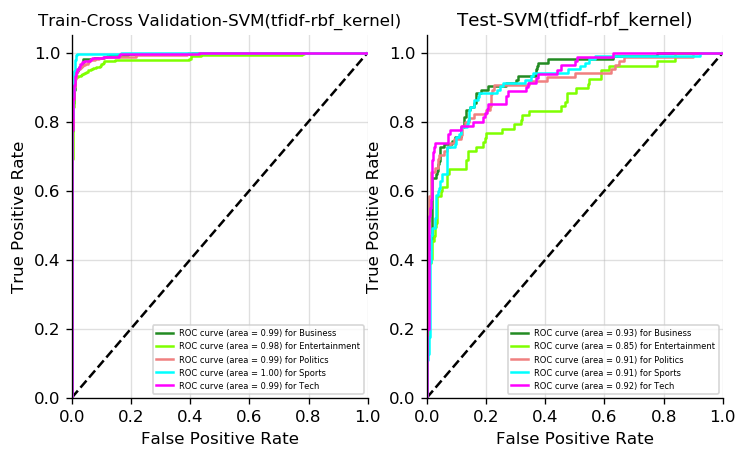

In [89]:
multiclass_roc_plot(svc_tfidf_ext_rbf, train_tfidf, train_y, test_tfidf_ext, test_y, 
                    title1='Train-Cross Validation-SVM(tfidf-rbf_kernel)', title2='Test-SVM(tfidf-rbf_kernel)')

### (Updated) Classifiers Prediction-Accuracy Evaluation

#### SVM(tfidf - rbf_kernel) (Before Optimization)

In [90]:
cl_df.head(1)

BOW   TF-IDF
SVM  60.225%  61.573%

#### Best-Prediction Classifier (Before Optimization)

In [91]:
cl_df[cl_df['TF-IDF'] == cl_df['TF-IDF'].max()]

BOW   TF-IDF
RF  66.966%  68.090%

####  SVM(tfidf - rbf_kernel) (After Optimization)

In [92]:
cl_ext_df.loc['SVM','TF-IDF'] = tfidf_ext_rbf_svc
cl_ext_df

TF-IDF
SVM  71.461%

###### *Before the SVM (tfidf - linear_kernel) optimization, the Random Forest classifier had the best results among all the classifiers concerning the prediction accuracy on the test set.<br>Yet, after the optimization SVM classifier's prediction accuracy rose by 115% (~71%) and became the most accurate among all the classifiers.<br>*

# <h1><center>CLUSTERING</center></h1>

##  ~ Bag of Words ~

### *Counts*

### K-Means

In [93]:
#if we normalise the train set data and run k-means with Euclidean distance metric,
#we get the same result, as if we had immediately run k-means with Cosine Similarity metric
train_bow_norm = preprocessing.normalize(train_bow)

In [94]:
km_bow = KMeans(n_clusters=5, init='k-means++', max_iter=300, random_state=0).fit(train_bow_norm)

In [95]:
#create a dataframe that contains k-means' predicted labels
km_bow_df = pd.DataFrame(data=km_bow.labels_, columns=["Category"])

### PCA

In [96]:
pca = PCA(n_components=2)
pca_bow = pca.fit_transform(train_bow_norm)

create a dataframe that contains the two principal components

In [97]:
pca_bow_df = pd.DataFrame(data=pca_bow, columns=['principal component 1', 'principal component 2'])

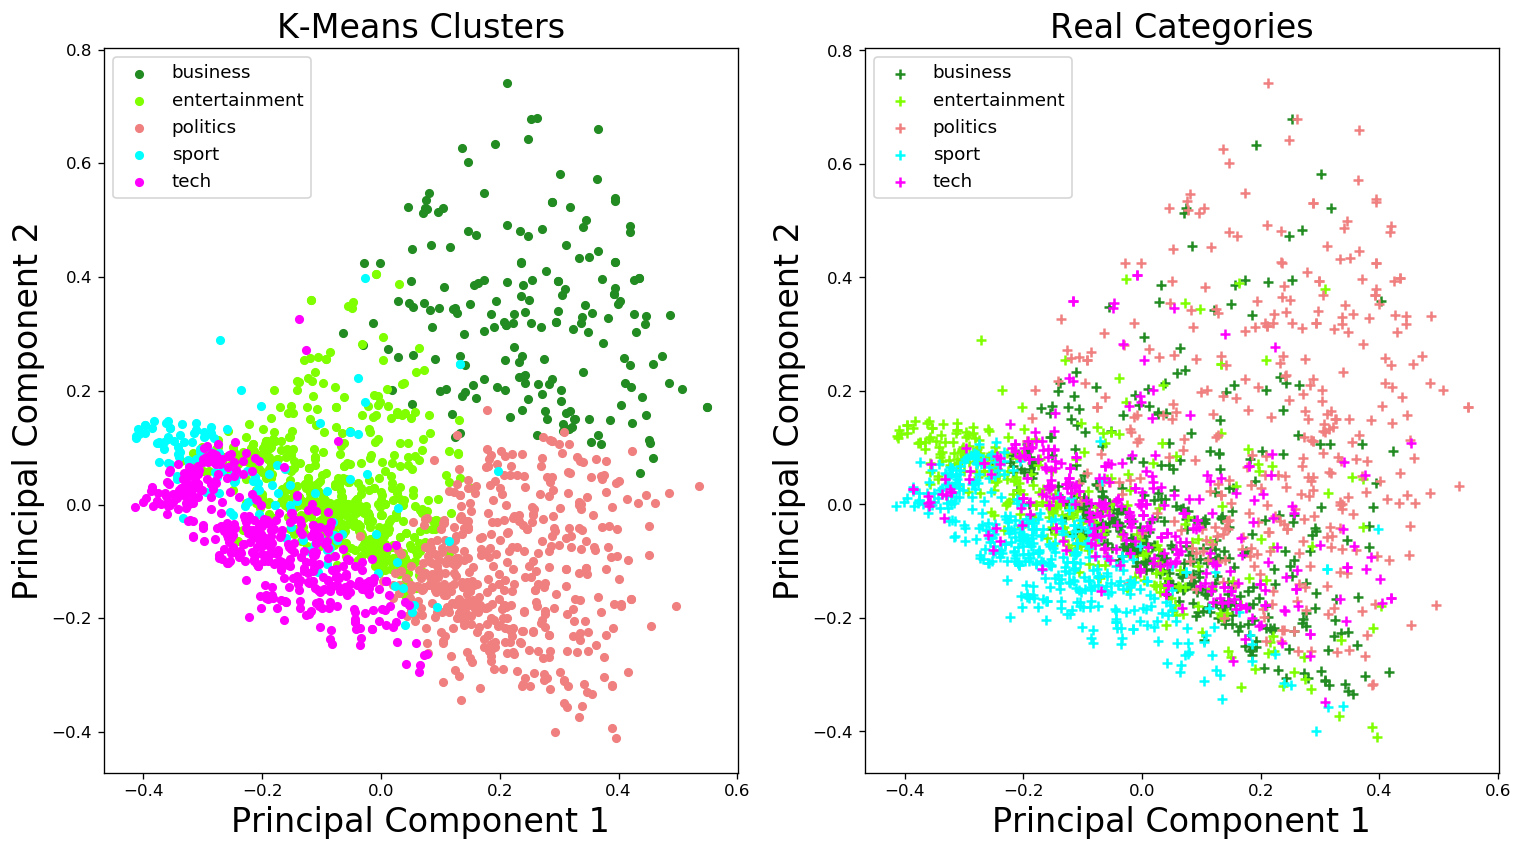

In [98]:
plt.figure(figsize=(15,8), dpi=120) 

classes = ['business', 'entertainment', 'politics', 'sport', 'tech']
colors = ['forestgreen', 'chartreuse', 'lightcoral', 'aqua', 'fuchsia']   
num_classes = [0, 1, 2, 3, 4]

plt.subplot(1,2,1)
plt.xlabel('Principal Component 1', fontsize=20)
plt.ylabel('Principal Component 2', fontsize=20)
plt.title("K-Means Clusters", fontsize=20)

for ncl, color in zip(num_classes,colors):
    index = km_bow_df['Category'] == ncl
    plt.scatter(pca_bow_df.loc[index, 'principal component 1'], 
                pca_bow_df.loc[index, 'principal component 2'], c = color, s = 20)

plt.legend(classes, prop={'size': 11})

plt.subplot(1,2,2)
plt.xlabel('Principal Component 1', fontsize=20)
plt.ylabel('Principal Component 2', fontsize=20)
plt.title("Real Categories", fontsize=20)

for cl, color in zip(classes,colors):
    index = train["Category"] == cl
    plt.scatter(pca_bow_df.loc[index, 'principal component 1'], 
                pca_bow_df.loc[index, 'principal component 2'], c = color, marker = "+", s = 30)

plt.legend(classes, prop={'size': 11})

### SVD

In [99]:
svd = TruncatedSVD(n_components=2)
svd_bow = svd.fit_transform(train_bow_norm)

create a dataframe that contains the two components

In [100]:
svd_bow_df = pd.DataFrame(data=svd_bow, columns=['component 1', 'component 2'])

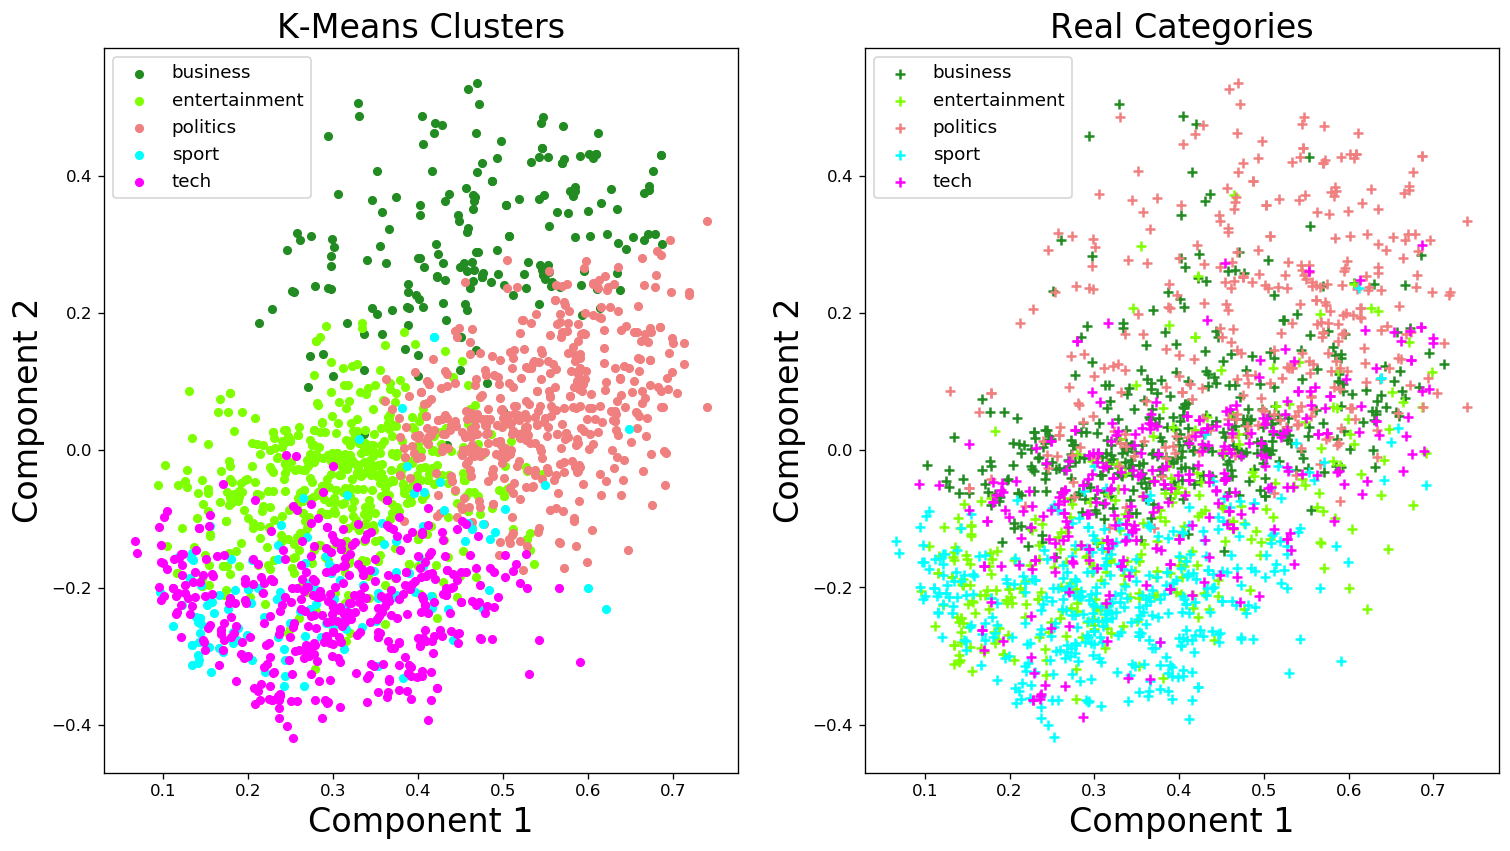

In [101]:
plt.figure(figsize=(15,8), dpi=120) 

classes = ['business', 'entertainment', 'politics', 'sport', 'tech']
colors = ['forestgreen', 'chartreuse', 'lightcoral', 'aqua', 'fuchsia']   
num_classes = [0, 1, 2, 3, 4]

plt.subplot(1,2,1)
plt.xlabel('Component 1', fontsize=20)
plt.ylabel('Component 2', fontsize=20)
plt.title("K-Means Clusters", fontsize=20)

for ncl, color in zip(num_classes,colors):
    index = km_bow_df['Category'] == ncl
    plt.scatter(svd_bow_df.loc[index, 'component 1'], 
                svd_bow_df.loc[index, 'component 2'], c = color, s = 20)

plt.legend(classes, prop={'size': 11})

plt.subplot(1,2,2)
plt.xlabel('Component 1', fontsize=20)
plt.ylabel('Component 2', fontsize=20)
plt.title("Real Categories", fontsize=20)

for cl, color in zip(classes,colors):
    index = train["Category"] == cl
    plt.scatter(svd_bow_df.loc[index, 'component 1'], 
                svd_bow_df.loc[index, 'component 2'], c = color, marker = "+", s = 30)

plt.legend(classes, prop={'size': 11})

### ICA

In [102]:
ica = FastICA(n_components=2, algorithm = 'deflation')
ica_bow = ica.fit_transform(train_bow_norm)

create a dataframe that contains the two independent components

In [103]:
ica_bow_df = pd.DataFrame(data=ica_bow, columns=['independent component 1', 'independent component 2'])

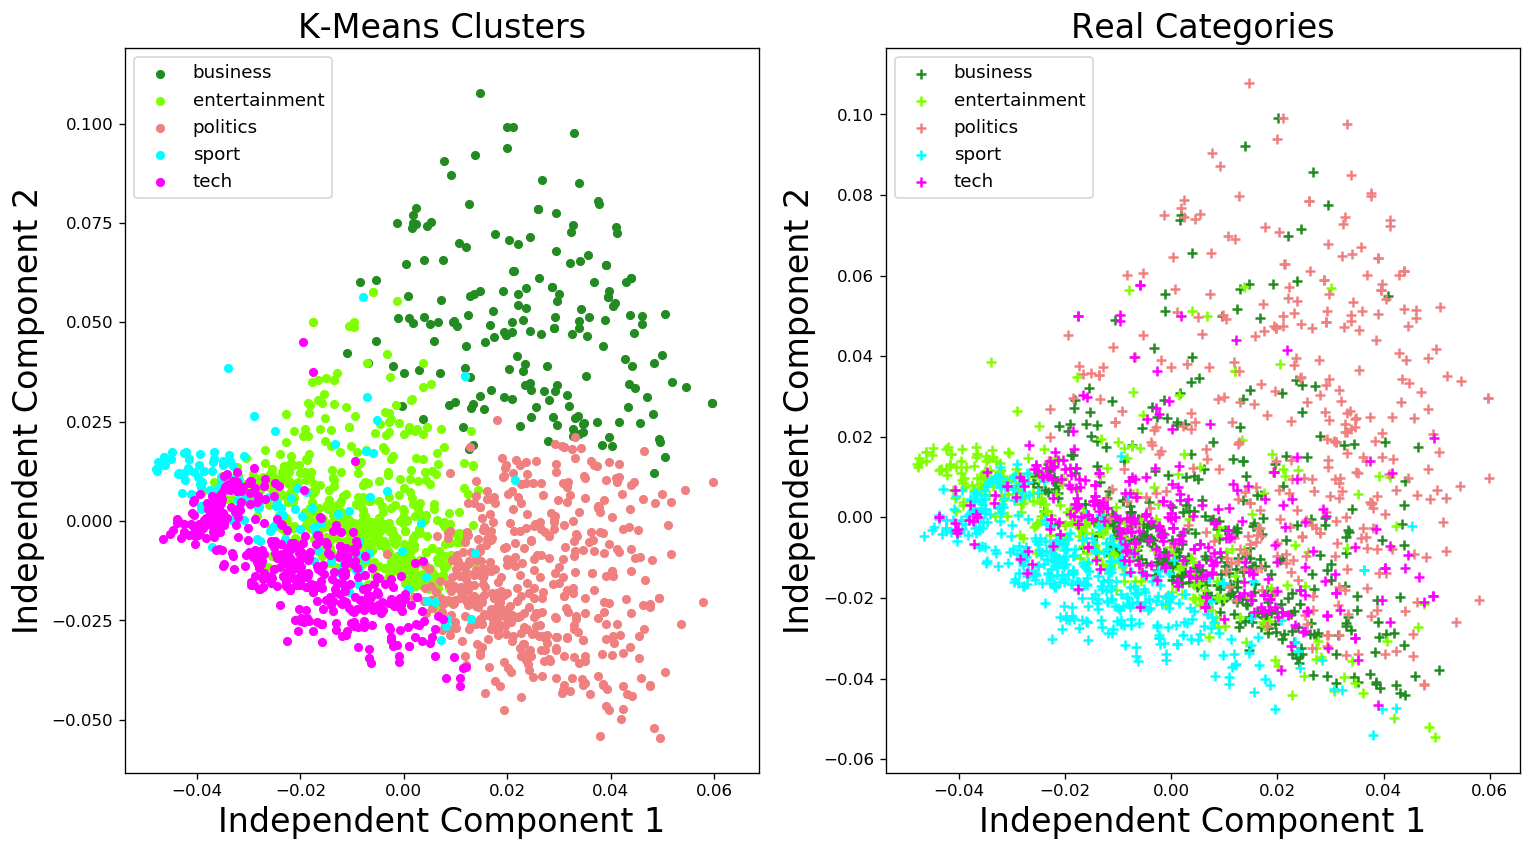

In [104]:
plt.figure(figsize=(15,8), dpi=120) 

classes = ['business', 'entertainment', 'politics', 'sport', 'tech']
colors = ['forestgreen', 'chartreuse', 'lightcoral', 'aqua', 'fuchsia']   
num_classes = [0, 1, 2, 3, 4]

plt.subplot(1,2,1)
plt.xlabel('Independent Component 1', fontsize=20)
plt.ylabel('Independent Component 2', fontsize=20)
plt.title("K-Means Clusters", fontsize=20)

for ncl, color in zip(num_classes,colors):
    index = km_bow_df['Category'] == ncl
    plt.scatter(ica_bow_df.loc[index, 'independent component 1'], 
                ica_bow_df.loc[index, 'independent component 2'], c = color, s = 20)

plt.legend(classes, prop={'size': 11})

plt.subplot(1,2,2)
plt.xlabel('Independent Component 1', fontsize=20)
plt.ylabel('Independent Component 2', fontsize=20)
plt.title("Real Categories", fontsize=20)

for cl, color in zip(classes,colors):
    index = train["Category"] == cl
    plt.scatter(ica_bow_df.loc[index, 'independent component 1'], 
                ica_bow_df.loc[index, 'independent component 2'], c = color, marker = "+", s = 30)

plt.legend(classes, prop={'size': 11})

### *Tf-Idf*

### K-Means

In [105]:
#if we normalise the train set data and run k-means with Euclidean distance metric,
#we get the same result, as if we had immediately run k-means with Cosine Similarity metric
train_tfidf_norm = preprocessing.normalize(train_tfidf)

In [106]:
km_tfidf = KMeans(n_clusters=5, init='k-means++', max_iter=300, random_state=0).fit(train_tfidf_norm)

In [107]:
#create a dataframe that contains k-means' predicted labels
km_tfidf_df = pd.DataFrame(data=km_tfidf.labels_, columns=["Category"])

### PCA

In [108]:
pca = PCA(n_components=2)
pca_tfidf = pca.fit_transform(train_tfidf_norm)

create a dataframe that contains the two principal components

In [109]:
pca_tfidf_df = pd.DataFrame(data=pca_tfidf, columns=['principal component 1', 'principal component 2'])

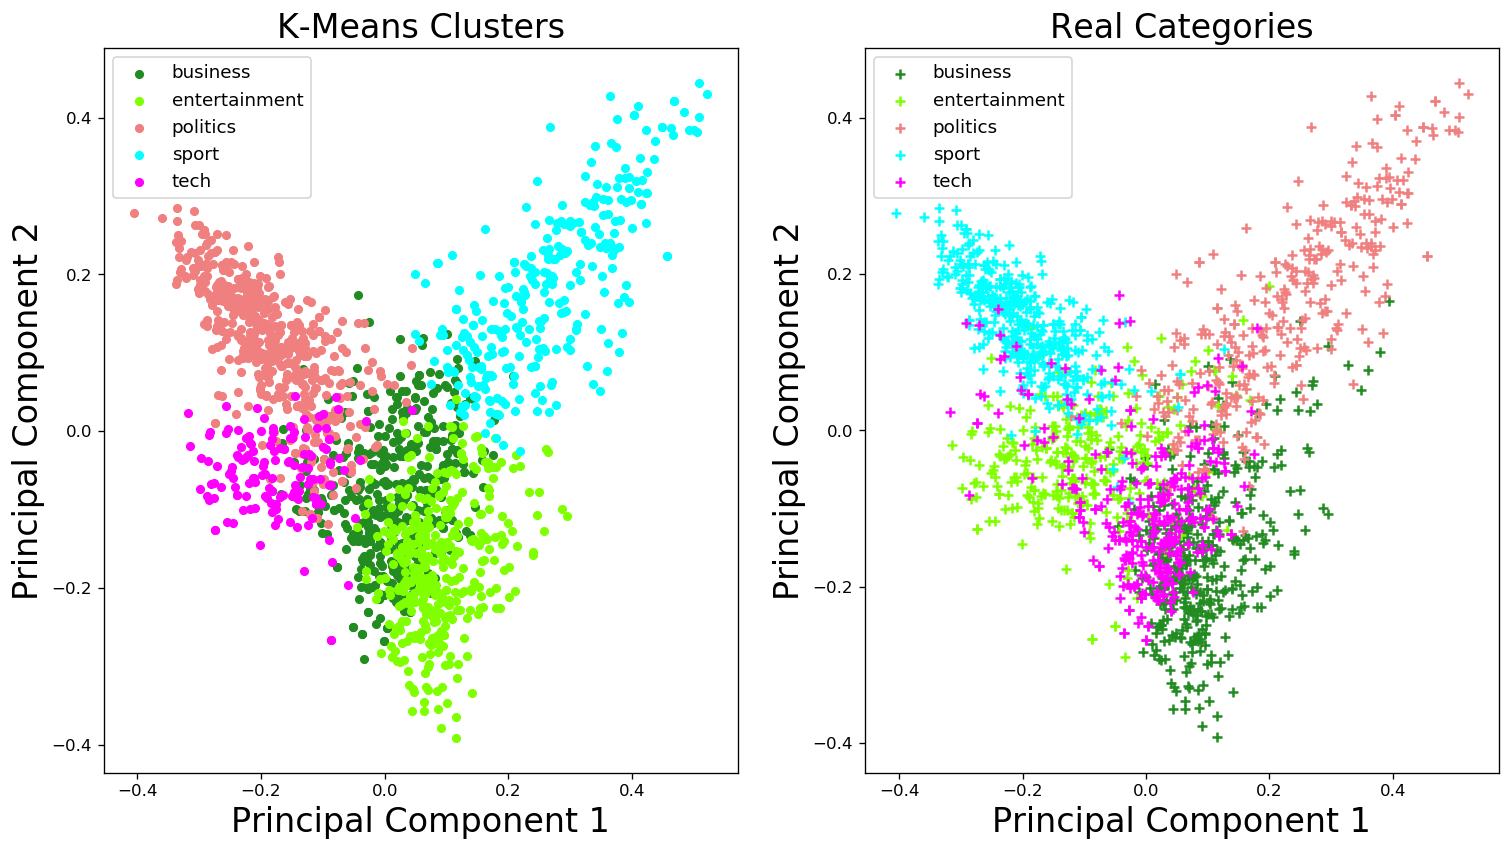

In [110]:
plt.figure(figsize=(15,8), dpi=120) 

classes = ['business', 'entertainment', 'politics', 'sport', 'tech']
colors = ['forestgreen', 'chartreuse', 'lightcoral', 'aqua', 'fuchsia']   
num_classes = [0, 1, 2, 3, 4]

plt.subplot(1,2,1)
plt.xlabel('Principal Component 1', fontsize=20)
plt.ylabel('Principal Component 2', fontsize=20)
plt.title("K-Means Clusters", fontsize=20)

for ncl, color in zip(num_classes,colors):
    index = km_tfidf_df['Category'] == ncl
    plt.scatter(pca_tfidf_df.loc[index, 'principal component 1'], 
                pca_tfidf_df.loc[index, 'principal component 2'], c = color, s = 20)

plt.legend(classes, prop={'size': 11})

plt.subplot(1,2,2)
plt.xlabel('Principal Component 1', fontsize=20)
plt.ylabel('Principal Component 2', fontsize=20)
plt.title("Real Categories", fontsize=20)

for cl, color in zip(classes,colors):
    index = train["Category"] == cl
    plt.scatter(pca_tfidf_df.loc[index, 'principal component 1'], 
                pca_tfidf_df.loc[index, 'principal component 2'], c = color, marker = "+", s = 30)

plt.legend(classes, prop={'size': 11})

### SVD

In [111]:
svd = TruncatedSVD(n_components=2)
svd_tfidf = svd.fit_transform(train_tfidf_norm)

create a dataframe that contains the two independent components

In [112]:
svd_tfidf_df = pd.DataFrame(data=svd_tfidf, columns=['component 1', 'component 2'])

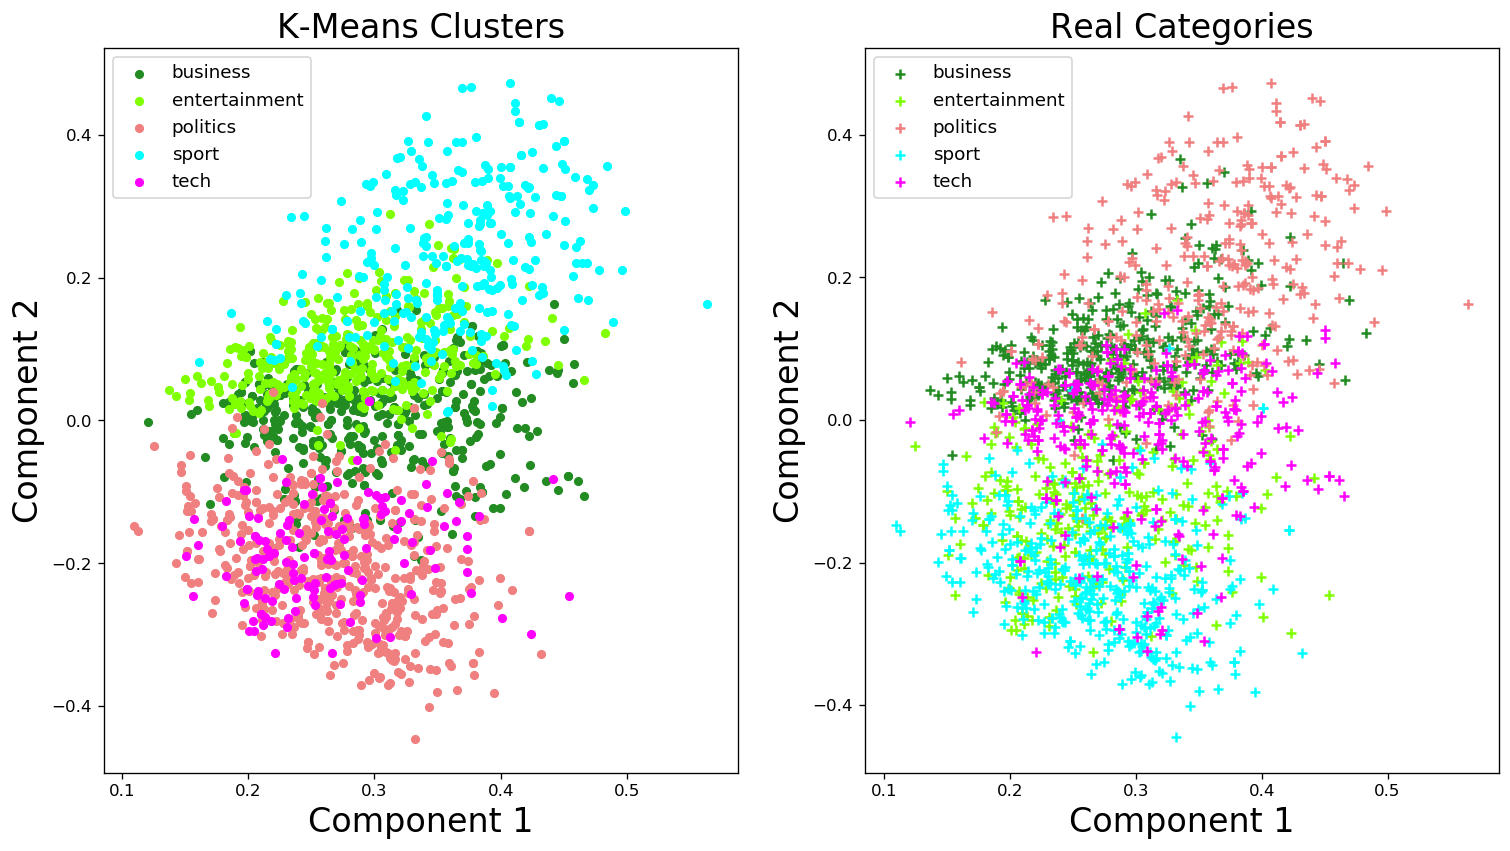

In [113]:
plt.figure(figsize=(15,8), dpi=120) 

classes = ['business', 'entertainment', 'politics', 'sport', 'tech']
colors = ['forestgreen', 'chartreuse', 'lightcoral', 'aqua', 'fuchsia']   
num_classes = [0, 1, 2, 3, 4]

plt.subplot(1,2,1)
plt.xlabel('Component 1', fontsize=20)
plt.ylabel('Component 2', fontsize=20)
plt.title("K-Means Clusters", fontsize=20)

for ncl, color in zip(num_classes,colors):
    index = km_tfidf_df['Category'] == ncl
    plt.scatter(svd_tfidf_df.loc[index, 'component 1'], 
                svd_tfidf_df.loc[index, 'component 2'], c = color, s = 20)

plt.legend(classes, prop={'size': 11})

plt.subplot(1,2,2)
plt.xlabel('Component 1', fontsize=20)
plt.ylabel('Component 2', fontsize=20)
plt.title("Real Categories", fontsize=20)

for cl, color in zip(classes,colors):
    index = train["Category"] == cl
    plt.scatter(svd_tfidf_df.loc[index, 'component 1'], 
                svd_tfidf_df.loc[index, 'component 2'], c = color, marker = "+", s = 30)

plt.legend(classes, prop={'size': 11})

### ICA

In [114]:
ica = FastICA(n_components=2, algorithm='deflation')
ica_tfidf = ica.fit_transform(train_tfidf_norm)

create a dataframe that contains the two independent components

In [115]:
ica_tfidf_df = pd.DataFrame(data=ica_tfidf, columns=['independent component 1', 'independent component 2'])

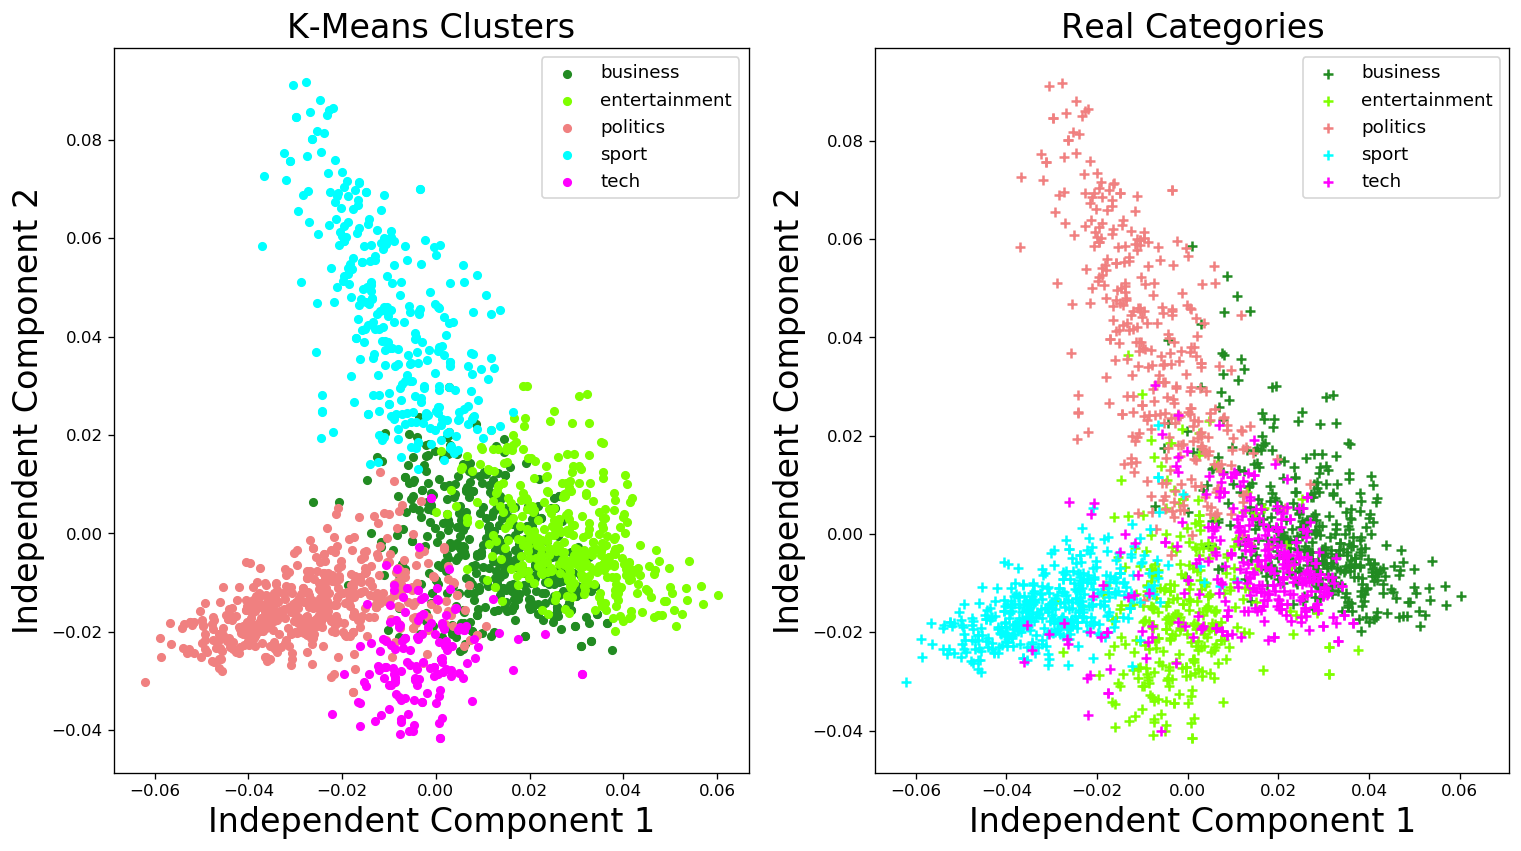

In [116]:
plt.figure(figsize=(15,8), dpi=120) 

classes = ['business', 'entertainment', 'politics', 'sport', 'tech']
colors = ['forestgreen', 'chartreuse', 'lightcoral', 'aqua', 'fuchsia']   
num_classes = [0, 1, 2, 3, 4]

plt.subplot(1,2,1)
plt.xlabel('Independent Component 1', fontsize=20)
plt.ylabel('Independent Component 2', fontsize=20)
plt.title("K-Means Clusters", fontsize=20)

for ncl, color in zip(num_classes,colors):
    index = km_tfidf_df['Category'] == ncl
    plt.scatter(ica_tfidf_df.loc[index, 'independent component 1'], 
                ica_tfidf_df.loc[index, 'independent component 2'], c = color, s = 20)

plt.legend(classes, prop={'size': 11})

plt.subplot(1,2,2)
plt.xlabel('Independent Component 1', fontsize=20)
plt.ylabel('Independent Component 2', fontsize=20)
plt.title("Real Categories", fontsize=20)

for cl, color in zip(classes,colors):
    index = train["Category"] == cl
    plt.scatter(ica_tfidf_df.loc[index, 'independent component 1'], 
                ica_tfidf_df.loc[index, 'independent component 2'], c = color, marker = "+", s = 30)

plt.legend(classes, prop={'size': 11})

## ~ Pre-trained Embeddings ~

### *Word2Vec*

In [117]:
w2v = Word2Vec(train['Tokens'], size=300, window=5, min_count=100, negative=10)
w2v_model = w2v.train(train['Tokens'], total_examples=len(train['Tokens']), epochs=20)

In [118]:
def tokens_to_vector(tokens, w2v):
    vectors = []
    
    for token in tokens:
        if token in w2v: #if word is part of the Word2Vec dictionary, add it to the list
            vectors.append(w2v[token]) 
        else:
            vectors.append((np.random.rand(300)*2 - 1)) # else, add a random word to the list
            
    total = np.zeros(300) 
    
    for v in vectors: #compute the mean vector
        total += v
        
    return total / len(vectors)   

In [119]:
vectors = []

for index, row in train.iterrows():
    vectors.append(tokens_to_vector(train.loc[index,'Tokens'], w2v)) 

#create a column in train set with articles' Word2Vec pre-trained embeddings
train['document-embeddings'] = pd.Series(vectors,index=train.index)

insert 'document-embeddings' column to array 

In [120]:
train_w2v = np.asarray(train['document-embeddings'].tolist())

### K-Means

In [121]:
#if we normalise the train set data and run k-means with Euclidean distance metric,
#we get the same result, as if we had immediately run k-means with Cosine Similarity metric
train_w2v_norm = preprocessing.normalize(train_w2v)

In [122]:
km_w2v = KMeans(n_clusters=5, init='k-means++', max_iter=300, random_state=0).fit(train_w2v_norm)

In [123]:
#create a dataframe that contains k-means' predicted labels
km_w2v_df = pd.DataFrame(data=km_w2v.labels_, columns=["Category"])

### PCA

In [124]:
pca = PCA(n_components=2)
pca_w2v = pca.fit_transform(train_w2v_norm)

create a dataframe that contains the two principal components

In [125]:
pca_w2v_df = pd.DataFrame(data=pca_w2v, columns=['principal component 1', 'principal component 2'])

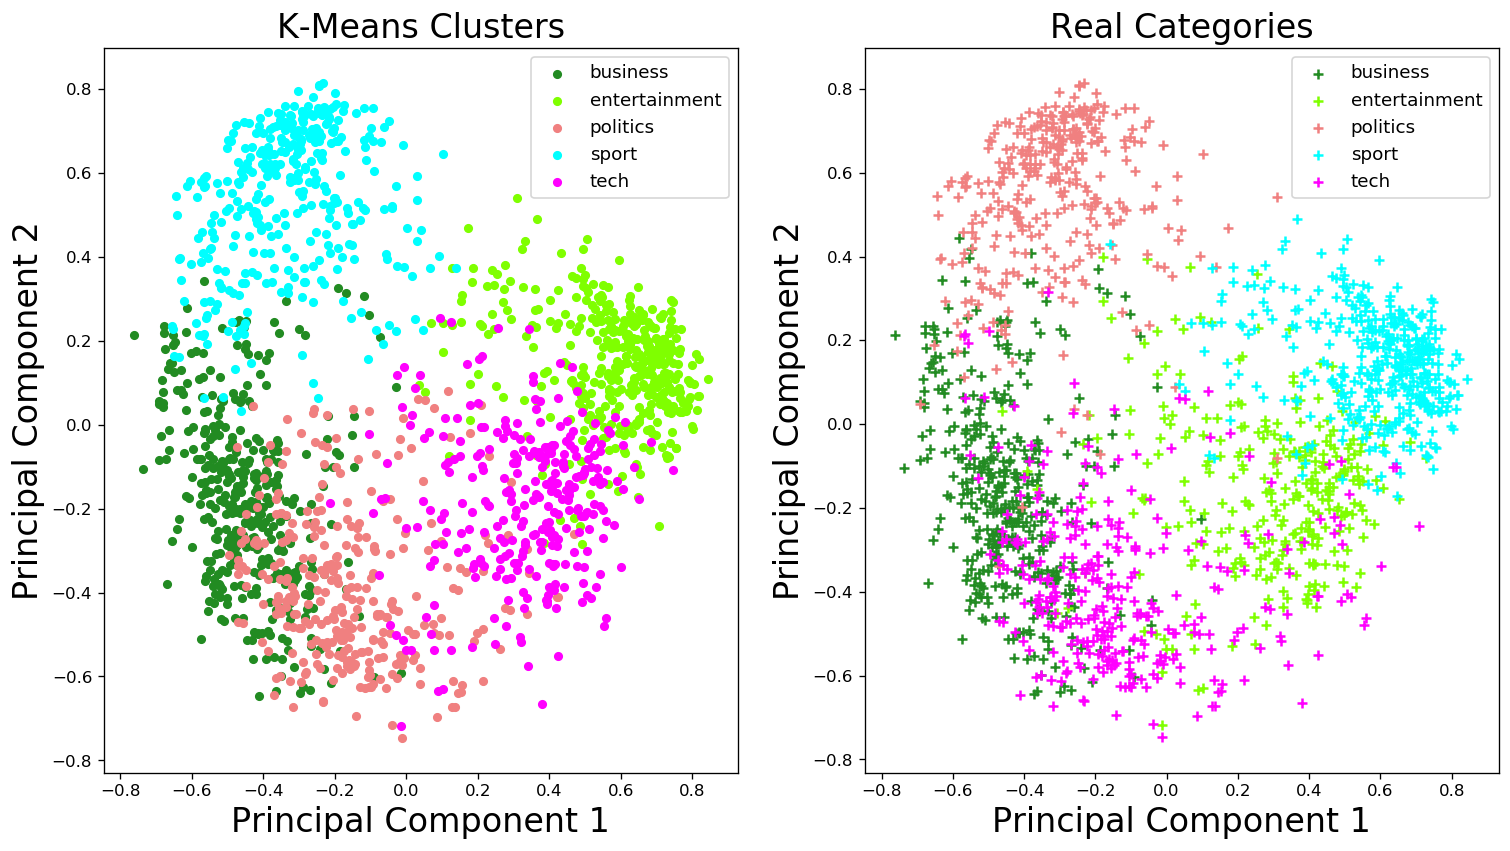

In [126]:
plt.figure(figsize=(15,8), dpi=120) 

classes = ['business', 'entertainment', 'politics', 'sport', 'tech']
colors = ['forestgreen', 'chartreuse', 'lightcoral', 'aqua', 'fuchsia']   
num_classes = [0, 1, 2, 3, 4]

plt.subplot(1,2,1)
plt.xlabel('Principal Component 1', fontsize=20)
plt.ylabel('Principal Component 2', fontsize=20)
plt.title("K-Means Clusters", fontsize=20)

for ncl, color in zip(num_classes,colors):
    index = km_w2v_df['Category'] == ncl
    plt.scatter(pca_w2v_df.loc[index, 'principal component 1'], 
                pca_w2v_df.loc[index, 'principal component 2'], c = color, s = 20)

plt.legend(classes, prop={'size': 11})

plt.subplot(1,2,2)
plt.xlabel('Principal Component 1', fontsize=20)
plt.ylabel('Principal Component 2', fontsize=20)
plt.title("Real Categories", fontsize=20)

for cl, color in zip(classes,colors):
    index = train["Category"] == cl
    plt.scatter(pca_w2v_df.loc[index, 'principal component 1'], 
                pca_w2v_df.loc[index, 'principal component 2'], c = color, marker = "+", s = 30)

plt.legend(classes, prop={'size': 11})

### SVD

In [127]:
svd = TruncatedSVD(n_components=2)
svd_w2v = svd.fit_transform(train_w2v_norm)

create a dataframe that contains the two components

In [128]:
svd_w2v_df = pd.DataFrame(data=svd_w2v, columns=['component 1', 'component 2'])

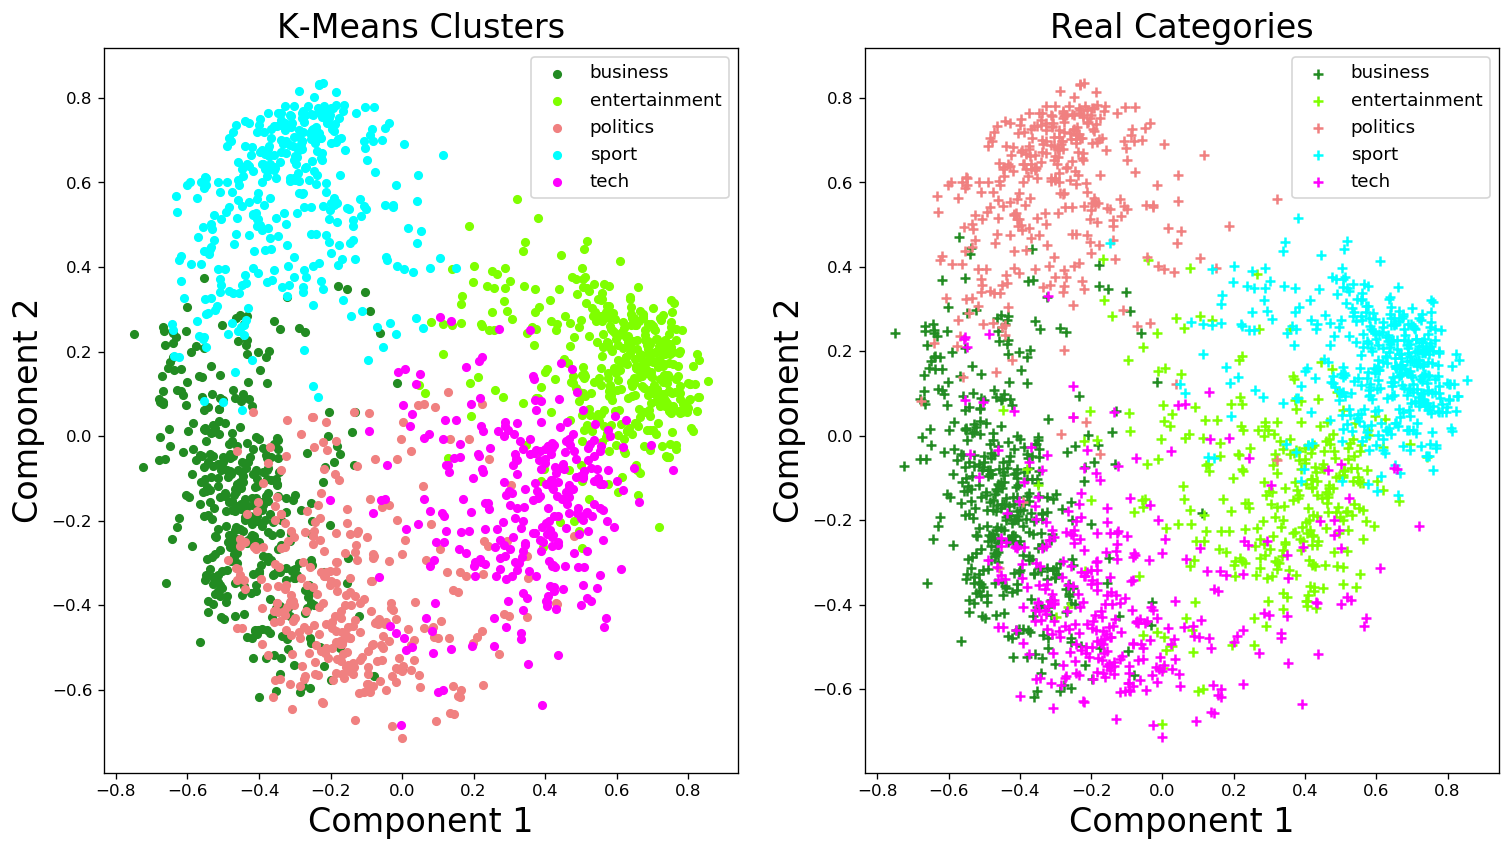

In [129]:
plt.figure(figsize=(15,8), dpi=120) 

classes = ['business', 'entertainment', 'politics', 'sport', 'tech']
colors = ['forestgreen', 'chartreuse', 'lightcoral', 'aqua', 'fuchsia']   
num_classes = [0, 1, 2, 3, 4]

plt.subplot(1,2,1)
plt.xlabel('Component 1', fontsize=20)
plt.ylabel('Component 2', fontsize=20)
plt.title("K-Means Clusters", fontsize=20)

for ncl, color in zip(num_classes,colors):
    index = km_w2v_df['Category'] == ncl
    plt.scatter(svd_w2v_df.loc[index, 'component 1'], 
                svd_w2v_df.loc[index, 'component 2'], c = color, s = 20)

plt.legend(classes, prop={'size': 11})

plt.subplot(1,2,2)
plt.xlabel('Component 1', fontsize=20)
plt.ylabel('Component 2', fontsize=20)
plt.title("Real Categories", fontsize=20)

for cl, color in zip(classes,colors):
    index = train["Category"] == cl
    plt.scatter(svd_w2v_df.loc[index, 'component 1'], 
                svd_w2v_df.loc[index, 'component 2'], c = color, marker = "+", s = 30)

plt.legend(classes, prop={'size': 11})

### ICA

In [130]:
ica = FastICA(n_components=2)
ica_w2v = ica.fit_transform(train_w2v_norm)

create a dataframe that contains the two independent components

In [131]:
ica_w2v_df = pd.DataFrame(data=ica_w2v, columns=['independent component 1', 'independent component 2'])

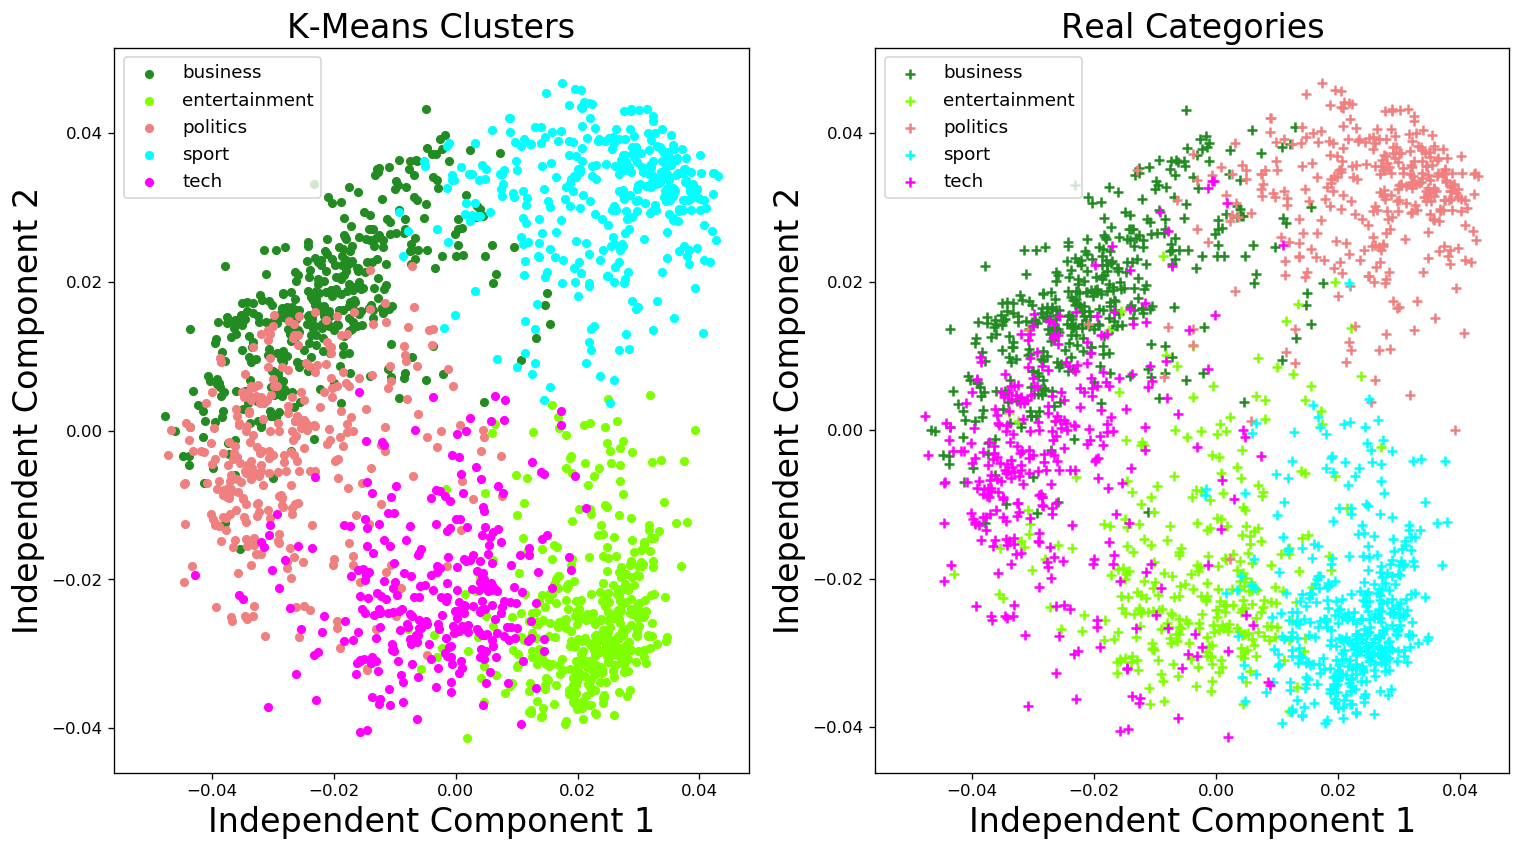

In [132]:
plt.figure(figsize=(15,8), dpi=120) 

classes = ['business', 'entertainment', 'politics', 'sport', 'tech']
colors = ['forestgreen', 'chartreuse', 'lightcoral', 'aqua', 'fuchsia']   
num_classes = [0, 1, 2, 3, 4]

plt.subplot(1,2,1)
plt.xlabel('Independent Component 1', fontsize=20)
plt.ylabel('Independent Component 2', fontsize=20)
plt.title("K-Means Clusters", fontsize=20)

for ncl, color in zip(num_classes,colors):
    index = km_w2v_df['Category'] == ncl
    plt.scatter(ica_w2v_df.loc[index, 'independent component 1'], 
                ica_w2v_df.loc[index, 'independent component 2'], c = color, s = 20)

plt.legend(classes, prop={'size': 11})

plt.subplot(1,2,2)
plt.xlabel('Independent Component 1', fontsize=20)
plt.ylabel('Independent Component 2', fontsize=20)
plt.title("Real Categories", fontsize=20)

for cl, color in zip(classes,colors):
    index = train["Category"] == cl
    plt.scatter(ica_w2v_df.loc[index, 'independent component 1'], 
                ica_w2v_df.loc[index, 'independent component 2'], c = color, marker = "+", s = 30)

plt.legend(classes, prop={'size': 11})